In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import random
random.seed(10)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from focal_loss import BinaryFocalLoss
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from tensorflow.keras import metrics
from tqdm.keras import TqdmCallback
from sklearn.utils.class_weight import compute_sample_weight
import pycountry


## Load Data

In [72]:
dfolder = '../data/'

In [73]:
df = pd.read_csv(dfolder + 'preprocessed_df.csv')

In [74]:
df['armedconf']

0         True
1         True
2         True
3         True
4         True
         ...  
54910    False
54911    False
54912    False
54913    False
54914    False
Name: armedconf, Length: 54915, dtype: bool

In [75]:
df

,isocode,month_year,month,year,Country Name,deaths_all_pc,armedconf,escalation,past6,past12,...,isocode_4,isocode_5,isocode_6,isocode_7,f3_target_escl,f6_target_escl,f3_target_clsf,f6_target_clsf,f3_target_regr,f6_target_regr
0,AFG,2000-01-01,1,2000,Afghanistan,0.276314,True,0,0.276314,0.276314,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,2000-02-01,2,2000,Afghanistan,0.777290,True,1,1.053604,1.053604,...,0,0,0,1,1.0,1.0,1.0,1.0,1.701424,1.600231
2,AFG,2000-03-01,3,2000,Afghanistan,1.620053,True,0,2.673657,2.673657,...,0,0,0,1,0.0,1.0,1.0,1.0,1.581843,2.404725
3,AFG,2000-04-01,4,2000,Afghanistan,2.706927,True,0,5.380585,5.380585,...,0,0,0,1,0.0,1.0,1.0,1.0,1.160851,3.083456
4,AFG,2000-05-01,5,2000,Afghanistan,0.418548,True,0,5.799133,5.799133,...,0,0,0,1,1.0,1.0,1.0,1.0,1.499038,2.822271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54910,ZWE,2022-11-01,11,2022,Zimbabwe,0.000000,False,0,0.000000,0.000000,...,0,1,0,1,0.0,NaN,0.0,NaN,0.000000,NaN
54911,ZWE,2022-12-01,12,2022,Zimbabwe,0.000000,False,0,0.000000,0.000000,...,0,1,0,1,0.0,NaN,0.0,NaN,0.000000,NaN
54912,ZWE,2023-01-01,1,2023,Zimbabwe,0.000000,False,0,0.000000,0.000000,...,0,1,0,1,0.0,NaN,0.0,NaN,0.000000,NaN
54913,ZWE,2023-02-01,2,2023,Zimbabwe,0.000000,False,0,0.000000,0.000000,...,0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN


## Preprocessing

In [76]:
def get_country_name(isocode):
    try:
        return pycountry.countries.get(alpha_3=isocode).name
    except AttributeError:
        if isocode == 'XKX':  # isocode for Kosovo
            return 'Kosovo'
        else:
            print(f"Error for isocode: {isocode}")
            return np.nan

df['country'] = df['isocode'].apply(get_country_name)


In [77]:
df['country'].dropna(inplace=True)

In [78]:
df['country'].isnull().sum()

0

In [79]:
print(df.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54915 entries, 0 to 54914
Data columns (total 89 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   isocode                54915 non-null  object 
 1   month_year             54915 non-null  object 
 2   month                  54915 non-null  int64  
 3   year                   54915 non-null  int64  
 4   Country Name           54915 non-null  object 
 5   deaths_all_pc          54915 non-null  float64
 6   armedconf              54915 non-null  bool   
 7   escalation             54915 non-null  int64  
 8   past6                  54915 non-null  float64
 9   past12                 54915 non-null  float64
 10  past60                 54915 non-null  float64
 11  past120                54915 non-null  float64
 12  armedconf_since        54915 non-null  int64  
 13  deaths_stock           54915 non-null  float64
 14  share_events_1         54915 non-null  float64
 15  sh

In [80]:
# df is your DataFrame
num_rows = len(df)
total_memory_MB = 48.5  # Your total memory usage in MB

memory_per_row_MB = total_memory_MB / num_rows

print(f"Memory usage per row: {memory_per_row_MB} MB")


Memory usage per row: 0.0008831831011563325 MB


In [81]:
df = df[df['country'].notna()]


In [82]:
print(df['country'].isnull().sum())  # should print 0


0


In [83]:
df = df.drop(columns=['month_year','isocode_0','isocode_1','isocode_2','isocode_3','isocode_4','isocode_5', 'isocode_6', 'isocode_7', 'f6_target_regr', 'f3_target_regr'])

In [84]:
df.columns

Index(['isocode', 'month', 'year', 'Country Name', 'deaths_all_pc',
       'armedconf', 'escalation', 'past6', 'past12', 'past60', 'past120',
       'armedconf_since', 'deaths_stock', 'share_events_1', 'share_events_2',
       'share_events_3', 'share_events_4', 'share_events_5', 'share_events_6',
       'share_events_7', 'share_events_8', 'share_events_9', 'share_events_10',
       'share_events_11', 'share_events_12', 'share_events_13',
       'share_events_14', 'share_events_15', 'share_events_16',
       'share_events_17', 'share_events_18', 'share_events_19',
       'share_events_20', 'share_events_gov', 'share_events_opp',
       'norm_total_events', 'event_share_1_stock', 'event_share_2_stock',
       'event_share_3_stock', 'event_share_4_stock', 'event_share_5_stock',
       'event_share_6_stock', 'event_share_7_stock', 'event_share_8_stock',
       'event_share_9_stock', 'event_share_10_stock', 'event_share_11_stock',
       'event_share_12_stock', 'event_share_13_stock', 'eve

In [85]:
armedconfdf = df

Here i'm taking the top 10 countries for model interpretability later.

In [86]:
top_10_countries=pd.DataFrame(armedconfdf.groupby('country')['armedconf'].sum()).sort_values(by='armedconf',ascending=False).reset_index()
top_10_country_names=top_10_countries.country[:11]

In [87]:
df.country.nunique()

197

In [88]:
df['armedconf'] = df['armedconf'].astype(int)
df['neighbor_conflict'] = df['neighbor_conflict'].astype(int)
df_final = df[df['year'] >= 2000]

Below we set the combination variables for our models. 

In [89]:
other_vars = ['month_sin', 'month_cos']

In [90]:
# Lists of variables to keep for each model (NB past currently only based on total number of deaths per )
id = ['isocode']

historical_vars = ['deaths_all_pc', 'armedconf', 'escalation', 'armedconf_since', 'deaths_stock', 'past6', 'past12', 'past60', 'past120',
                   'share_state_deaths', 'share_nonstate_deaths', 'share_onesided_deaths', 'share_civilian_deaths',
                   'refugees_in', 'refugees_out', 'neighbor_conflict'] + other_vars + ['country', 'year', 'month']

event_shares = ['share_events_{}'.format(i) for i in range(1, 21)] 
event_share_stock = ['event_share_{}_stock'.format(i) for i in range(1, 21)]
event_share_actor = ['share_events_gov', 'share_events_opp']
event_total = ['norm_total_events']
gdelt_admin1 = ['num_regions', 'Adm1_Max', 'Adm1_Mean', 'Adm1_Median']

clusters = ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3']


text_gdelt_vars = event_shares + event_share_stock + event_share_actor + event_total + gdelt_admin1 + clusters + other_vars + ['country', 'year', 'month']

In [91]:
combination_vars = text_gdelt_vars + historical_vars

In [92]:
historical_vars = set(historical_vars)
text_gdelt_vars = set(text_gdelt_vars)
combination_vars = list(historical_vars.union(text_gdelt_vars))
historical_vars = list(historical_vars)
text_gdelt_vars = list(text_gdelt_vars)

In [93]:
combination_vars

['share_events_12',
 'past6',
 'past120',
 'cluster_3',
 'event_share_10_stock',
 'share_events_6',
 'event_share_1_stock',
 'event_share_8_stock',
 'share_events_18',
 'Adm1_Median',
 'event_share_19_stock',
 'refugees_out',
 'month',
 'event_share_17_stock',
 'year',
 'share_events_5',
 'num_regions',
 'share_onesided_deaths',
 'share_events_gov',
 'norm_total_events',
 'event_share_6_stock',
 'cluster_1',
 'past12',
 'share_events_3',
 'share_events_15',
 'event_share_15_stock',
 'refugees_in',
 'neighbor_conflict',
 'share_events_20',
 'month_sin',
 'share_events_9',
 'event_share_4_stock',
 'cluster_2',
 'cluster_0',
 'share_nonstate_deaths',
 'month_cos',
 'event_share_2_stock',
 'Adm1_Mean',
 'event_share_14_stock',
 'armedconf_since',
 'country',
 'share_civilian_deaths',
 'share_events_2',
 'share_state_deaths',
 'share_events_opp',
 'event_share_9_stock',
 'share_events_10',
 'share_events_4',
 'deaths_stock',
 'share_events_7',
 'share_events_8',
 'Adm1_Max',
 'event_share_7

In [94]:
text_gdelt_vars

['share_events_12',
 'share_events_10',
 'event_share_9_stock',
 'share_events_4',
 'cluster_3',
 'event_share_10_stock',
 'share_events_7',
 'share_events_6',
 'share_events_8',
 'event_share_1_stock',
 'event_share_8_stock',
 'share_events_18',
 'Adm1_Max',
 'event_share_19_stock',
 'event_share_7_stock',
 'event_share_17_stock',
 'Adm1_Median',
 'event_share_18_stock',
 'month',
 'share_events_5',
 'year',
 'num_regions',
 'share_events_gov',
 'norm_total_events',
 'event_share_6_stock',
 'share_events_16',
 'event_share_5_stock',
 'cluster_1',
 'share_events_13',
 'share_events_3',
 'share_events_15',
 'event_share_15_stock',
 'share_events_20',
 'month_sin',
 'share_events_17',
 'share_events_9',
 'event_share_4_stock',
 'cluster_2',
 'share_events_11',
 'share_events_19',
 'cluster_0',
 'event_share_20_stock',
 'month_cos',
 'share_events_1',
 'event_share_2_stock',
 'event_share_3_stock',
 'Adm1_Mean',
 'event_share_14_stock',
 'event_share_16_stock',
 'country',
 'event_share_1

In [95]:
historical_vars

['past6',
 'past120',
 'deaths_stock',
 'refugees_out',
 'month',
 'year',
 'share_onesided_deaths',
 'past12',
 'deaths_all_pc',
 'refugees_in',
 'neighbor_conflict',
 'escalation',
 'month_sin',
 'past60',
 'share_nonstate_deaths',
 'month_cos',
 'armedconf',
 'armedconf_since',
 'country',
 'share_civilian_deaths',
 'share_state_deaths']

### Train Test Split and Preprocess

In [96]:
def train_test_split_year(data, year, target_variable):
    x_train = data[data.index.get_level_values('year') < year].drop(columns=[target_variable])
    y_train = data[data.index.get_level_values('year') < year][target_variable]
    x_test = data[data.index.get_level_values('year') >= year].drop(columns=[target_variable])
    y_test = data[data.index.get_level_values('year') >= year][target_variable]
    return x_train, x_test, y_train, y_test

def preprocess_data(df, variables, split_year, target_variable):
    # copy the dataframe and set multi-index
    conf = df[variables].copy()
    conf['country'] = list(conf.country)
    print(conf.columns)
    conf = conf.set_index(['isocode', 'year', 'month'])

    # split data for each country and append to lists
    X_train, X_test, Y_train, Y_test = [], [], [], []
    for country in conf['country'].unique():
        data = conf[conf['country'] == country]
        x_train, x_test, y_train, y_test = train_test_split_year(data, split_year, target_variable)
        X_train.append(x_train)
        X_test.append(x_test)
        Y_train.append(y_train)
        Y_test.append(y_test)

    # concatenate train and test data from each country
    X_train = pd.concat(X_train)
    Y_train = pd.concat(Y_train)
    X_test = pd.concat(X_test)
    Y_test = pd.concat(Y_test)

    # concatenate X and Y dataframes
    train = pd.concat([X_train, Y_train], axis=1)
    test = pd.concat([X_test, Y_test], axis=1)

    return train, test


## Normalizing

In [97]:
def normalize_data(train, test, target_variable):
    # save indices and 'country' and target column
    train_index = train.index
    test_index = test.index
    train_country = train['country']
    test_country = test['country']
    train_target = train[target_variable]
    test_target = test[target_variable]

    # initialize scaler
    scaler = MinMaxScaler(feature_range=(0, 1))

    # scale train and test data, excluding 'country' and target column
    scaled_train = scaler.fit_transform(train.drop(columns=['country', target_variable]))
    scaled_test = scaler.transform(test.drop(columns=['country', target_variable]))

    # convert back to DataFrame and add columns and index back
    scaled_train = pd.DataFrame(data=scaled_train, columns=train.drop(columns=['country', target_variable]).columns, index=train_index)
    scaled_test = pd.DataFrame(data=scaled_test, columns=test.drop(columns=['country', target_variable]).columns, index=test_index)

    # add 'country' and target column back
    scaled_train['country'] = train_country
    scaled_test['country'] = test_country
    print(train_target)
    scaled_train[target_variable] = train_target
    scaled_test[target_variable] = test_target

    return scaled_train, scaled_test


## Model

In [98]:
def series_to_supervised_modified(data, group_by_level, target_column_index, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        group_by_level: The level name to group by (e.g. 'isocode').
        target_column_index: The index of the target column in data
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t)
    for i in range(n_in, -1, -1):
        shifted = df.drop(columns=df.columns[target_column_index]).groupby(level=group_by_level).shift(i) #shift and exclude target
        cols.append(shifted)
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars) if j != target_column_index] # this excludes the target at t-0 when we do forward 6, forward 3 or text 
    # forecast sequence (t+1)
    shifted_target = df.groupby(level=group_by_level)[df.columns[target_column_index]].shift(-n_out)
    cols.append(shifted_target)
    names += ['var%d(t+%d)' % (target_column_index+1, n_out)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [99]:
def series_to_supervised(data, group_by_level, target_column_index, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        group_by_level: The level name to group by (e.g. 'isocode').
        target_column_index: The index of the target column in data
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t)
    for i in range(n_in, -1, -1):
        shifted = df.groupby(level=group_by_level).shift(i) # shift input 
        cols.append(shifted)
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t+1)
    shifted_target = df.groupby(level=group_by_level)[df.columns[target_column_index]].shift(-n_out) #shift output
    cols.append(shifted_target)
    names += ['var%d(t+%d)' % (target_column_index+1, n_out)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [100]:
def reshape_data(train, test, target, modified=False):
    """
    Reshape 'train' and 'test' dataframes into a format suitable for supervised learning,
    splitting them into input features (X) and target labels (y), and reshaping input 
    features into a 3D format required by LSTM models in Keras.

    Arguments:
        train: Training dataframe, with the last column being the target column.
        test: Test dataframe, with the last column being the target column.
        data_type: String indicating type of data ('text' or 'other').

    Returns:
        x_train: Input features for training data, reshaped into 3D format.
        x_test: Input features for test data, reshaped into 3D format.
        y_train: Target labels for training data.
        y_test: Target labels for test data.
        reframed_train: Training data transformed into a supervised learning format.
        reframed_test: Test data transformed into a supervised learning format.
    """
    
    # get the index of the target column
    target_column_index_train = train.columns.tolist().index(target)
    target_column_index_test = test.columns.tolist().index(target)

    # frame as supervised learning and drop all time t columns except the target
    if modified == True:
        reframed_train = series_to_supervised_modified(train, 'isocode', target_column_index_train, 1, 1)
        reframed_test = series_to_supervised_modified(test, 'isocode', target_column_index_test, 1, 1)
    else:
        reframed_train = series_to_supervised(train, 'isocode', target_column_index_train, 1, 1)
        reframed_test = series_to_supervised(test, 'isocode', target_column_index_test, 1, 1)
    print(reframed_train)
    # split into train and test sets
    train_values = reframed_train.values
    test_values = reframed_test.values

    # split into input and outputs
    train_X, y_train = train_values[:, :-1], train_values[:, -1]
    test_X, y_test = test_values[:, :-1], test_values[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    return x_train, x_test, y_train, y_test, reframed_train, reframed_test


In [101]:
def prepare_data_for_model(scaled_train, scaled_test, target):
    # create a helper function to prepare a dataframe
    def prepare_df(df, target, encoder=None):
        non_country_cols = [col for col in df.columns if col != 'country' and col != target]

        # create a new dataframe
        df_data = pd.DataFrame()

        # Add all non-country and non-target columns
        for col in non_country_cols:
            df_data[col] = df[col]
        
        # if encoder is None, fit the encoder and transform 'country'
        if encoder is None:
            encoder = LabelEncoder()
            df_data['country'] = encoder.fit_transform(df['country'])
        else:
            df_data['country'] = encoder.transform(df['country'])

        df_data[target] = df[target]
        
        # move target column to the end
        df_data[target] = df_data.pop(target)
        
        return df_data, encoder

    # prepare train and test data
    train_data, encoder = prepare_df(scaled_train, target, None)
    test_data, _ = prepare_df(scaled_test, target, encoder)

    return train_data, test_data, encoder


In [102]:
def train_and_evaluate_model(x_train, x_test, y_train, y_test, model, target_name):
    # compute class weights
    class_weights = compute_sample_weight(class_weight='balanced', y=y_train)
    class_weights = dict(enumerate(class_weights))

    # set up early stopping
    early_stop = EarlyStopping(monitor='loss', patience=3)

    # train the given model with class weights
    history = model.fit(x_train, y_train, epochs=25, batch_size=120, class_weight=class_weights, verbose=0, shuffle=False, callbacks=[early_stop, TqdmCallback(verbose=2)])

    # plot training history
    plt.plot(history.history['loss'], label='Train Loss')
    plt.legend()
    plt.show()

    # make predictions
    y_pred = model.predict(x_test)
    y_pred_binary = (y_pred > 0.5).astype(int)  # convert probabilities to binary output

    # calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    report = classification_report(y_test, y_pred_binary)

    # return a dictionary of results
    return {'model': model, 
            'target': target_name,
            'y_test': y_test, 
            'y_pred': y_pred, 
            'accuracy': accuracy, 
            'recall': recall,
            'precision': precision,
            'report': report,
            }

In [103]:
def run_pipeline(df, target_variable, variables, split_year, modified):

    variables = variables.copy()
    
    if target_variable not in variables: 
        variables.append(target_variable)
        
    if 'isocode' not in variables:
        variables.append('isocode')
    
    if target_variable.startswith(('f3', 'f6')): 
        modified = True

    # preprocess data
    train, test = preprocess_data(df, variables, split_year, target_variable)
    
    # normalize 
    scaled_train, scaled_test = normalize_data(train, test, target_variable)
    
    # prepare data for lstm model
    train_data, test_data, encoder = prepare_data_for_model(scaled_train, scaled_test, target_variable)
    
    # reshape data
    x_train, x_test, y_train, y_test, reframed_train, reframed_test = reshape_data(train_data, test_data, target_variable, modified)
    
    # define model 
    model = Sequential()
    model.add(LSTM(60, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    loss = BinaryFocalLoss(gamma=2., pos_weight=3)
    model.compile(loss=loss, optimizer=Adam(learning_rate=0.001), metrics=['accuracy', metrics.Recall()])
    
    # train and evaluate model
    results = train_and_evaluate_model(x_train, x_test, y_train, y_test, model, target_variable)
    
    return results, encoder, reframed_train, reframed_test, scaled_test

In [104]:
all_results = []

Running pipeline for target variable: f6_target_escl
Index(['share_events_12', 'past6', 'past120', 'cluster_3',
       'event_share_10_stock', 'share_events_6', 'event_share_1_stock',
       'event_share_8_stock', 'share_events_18', 'Adm1_Median',
       'event_share_19_stock', 'refugees_out', 'month', 'event_share_17_stock',
       'year', 'share_events_5', 'num_regions', 'share_onesided_deaths',
       'share_events_gov', 'norm_total_events', 'event_share_6_stock',
       'cluster_1', 'past12', 'share_events_3', 'share_events_15',
       'event_share_15_stock', 'refugees_in', 'neighbor_conflict',
       'share_events_20', 'month_sin', 'share_events_9', 'event_share_4_stock',
       'cluster_2', 'cluster_0', 'share_nonstate_deaths', 'month_cos',
       'event_share_2_stock', 'Adm1_Mean', 'event_share_14_stock',
       'armedconf_since', 'country', 'share_civilian_deaths', 'share_events_2',
       'share_state_deaths', 'share_events_opp', 'event_share_9_stock',
       'share_events_10'

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-02 22:26:27.259243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:26:27.469094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:26:27.706250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

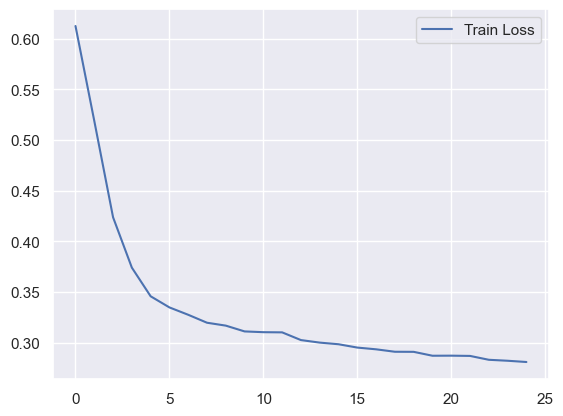

 18/345 [>.............................] - ETA: 0s  

2023-07-02 22:28:07.850279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:28:07.900109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


345/345 [==============================] - 1s 2ms/step
Index(['share_events_12', 'share_events_10', 'event_share_9_stock',
       'share_events_4', 'cluster_3', 'event_share_10_stock', 'share_events_7',
       'share_events_6', 'share_events_8', 'event_share_1_stock',
       'event_share_8_stock', 'share_events_18', 'Adm1_Max',
       'event_share_19_stock', 'event_share_7_stock', 'event_share_17_stock',
       'Adm1_Median', 'event_share_18_stock', 'month', 'share_events_5',
       'year', 'num_regions', 'share_events_gov', 'norm_total_events',
       'event_share_6_stock', 'share_events_16', 'event_share_5_stock',
       'cluster_1', 'share_events_13', 'share_events_3', 'share_events_15',
       'event_share_15_stock', 'share_events_20', 'month_sin',
       'share_events_17', 'share_events_9', 'event_share_4_stock', 'cluster_2',
       'share_events_11', 'share_events_19', 'cluster_0',
       'event_share_20_stock', 'month_cos', 'share_events_1',
       'event_share_2_stock', 'event_

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-02 22:28:10.621107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:28:10.809333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:28:11.022925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

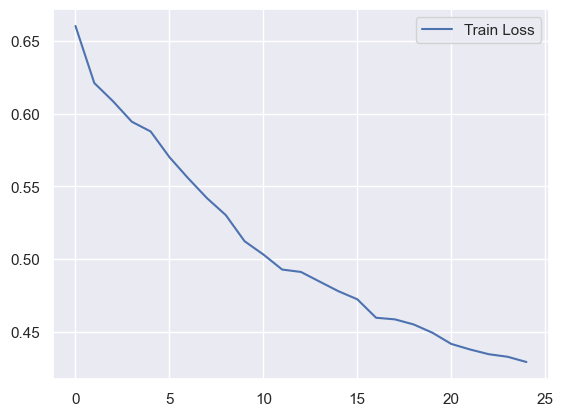

 17/345 [>.............................] - ETA: 1s  

2023-07-02 22:30:00.298779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:30:00.351201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


345/345 [==============================] - 1s 3ms/step
Index(['past6', 'past120', 'deaths_stock', 'refugees_out', 'month', 'year',
       'share_onesided_deaths', 'past12', 'deaths_all_pc', 'refugees_in',
       'neighbor_conflict', 'escalation', 'month_sin', 'past60',
       'share_nonstate_deaths', 'month_cos', 'armedconf', 'armedconf_since',
       'country', 'share_civilian_deaths', 'share_state_deaths',
       'f6_target_escl', 'isocode'],
      dtype='object')
isocode  year  month
AFG      2000  1        NaN
               2        1.0
               3        1.0
               4        1.0
               5        1.0
                       ... 
ZWE      2017  8        0.0
               9        1.0
               10       1.0
               11       1.0
               12       1.0
Name: f6_target_escl, Length: 42504, dtype: float64
                    var1(t-1)  var2(t-1)     var3(t-1)  var4(t-1)  var5(t-1)  \
isocode year month                                                  

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-02 22:30:02.851129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:30:03.046309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:30:03.299667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

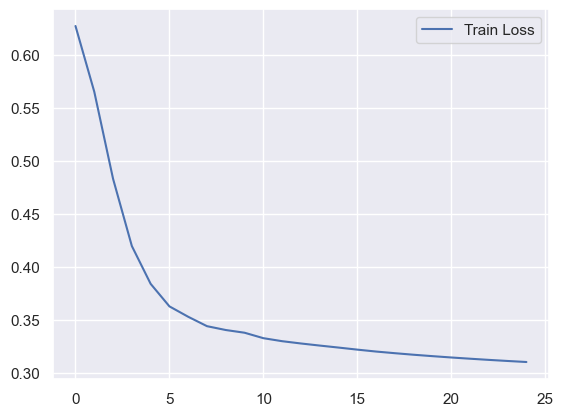

 17/345 [>.............................] - ETA: 1s  

2023-07-02 22:31:57.380299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:31:57.435413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


345/345 [==============================] - 1s 3ms/step
Running pipeline for target variable: f3_target_escl
Index(['share_events_12', 'past6', 'past120', 'cluster_3',
       'event_share_10_stock', 'share_events_6', 'event_share_1_stock',
       'event_share_8_stock', 'share_events_18', 'Adm1_Median',
       'event_share_19_stock', 'refugees_out', 'month', 'event_share_17_stock',
       'year', 'share_events_5', 'num_regions', 'share_onesided_deaths',
       'share_events_gov', 'norm_total_events', 'event_share_6_stock',
       'cluster_1', 'past12', 'share_events_3', 'share_events_15',
       'event_share_15_stock', 'refugees_in', 'neighbor_conflict',
       'share_events_20', 'month_sin', 'share_events_9', 'event_share_4_stock',
       'cluster_2', 'cluster_0', 'share_nonstate_deaths', 'month_cos',
       'event_share_2_stock', 'Adm1_Mean', 'event_share_14_stock',
       'armedconf_since', 'country', 'share_civilian_deaths', 'share_events_2',
       'share_state_deaths', 'share_event

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-02 22:32:00.263629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:32:00.464080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:32:00.766253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

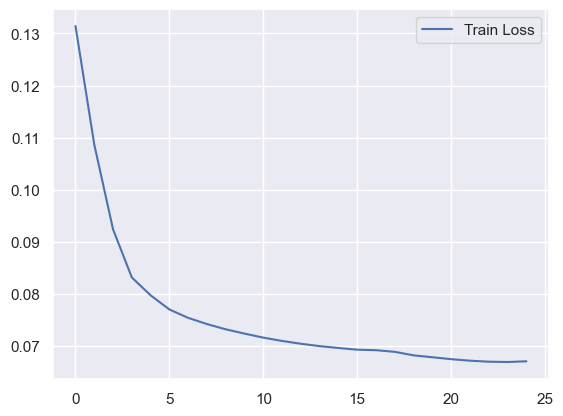

  7/364 [..............................] - ETA: 3s  

2023-07-02 22:33:57.327263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:33:57.391593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


364/364 [==============================] - 1s 3ms/step
Index(['share_events_12', 'share_events_10', 'event_share_9_stock',
       'share_events_4', 'cluster_3', 'event_share_10_stock', 'share_events_7',
       'share_events_6', 'share_events_8', 'event_share_1_stock',
       'event_share_8_stock', 'share_events_18', 'Adm1_Max',
       'event_share_19_stock', 'event_share_7_stock', 'event_share_17_stock',
       'Adm1_Median', 'event_share_18_stock', 'month', 'share_events_5',
       'year', 'num_regions', 'share_events_gov', 'norm_total_events',
       'event_share_6_stock', 'share_events_16', 'event_share_5_stock',
       'cluster_1', 'share_events_13', 'share_events_3', 'share_events_15',
       'event_share_15_stock', 'share_events_20', 'month_sin',
       'share_events_17', 'share_events_9', 'event_share_4_stock', 'cluster_2',
       'share_events_11', 'share_events_19', 'cluster_0',
       'event_share_20_stock', 'month_cos', 'share_events_1',
       'event_share_2_stock', 'event_

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-02 22:34:00.264283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:34:00.459772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:34:00.754968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

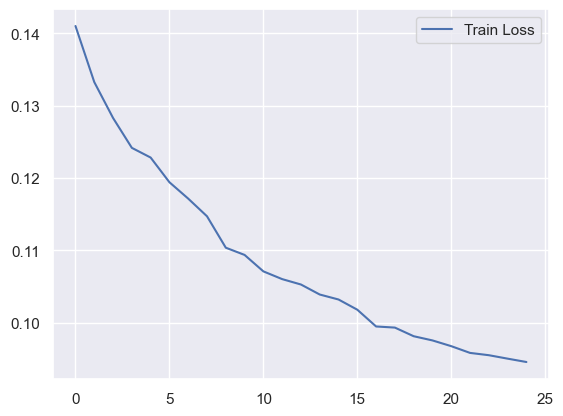

  6/364 [..............................] - ETA: 3s  

2023-07-02 22:35:53.666773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:35:53.721311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


364/364 [==============================] - 1s 3ms/step
Index(['past6', 'past120', 'deaths_stock', 'refugees_out', 'month', 'year',
       'share_onesided_deaths', 'past12', 'deaths_all_pc', 'refugees_in',
       'neighbor_conflict', 'escalation', 'month_sin', 'past60',
       'share_nonstate_deaths', 'month_cos', 'armedconf', 'armedconf_since',
       'country', 'share_civilian_deaths', 'share_state_deaths',
       'f3_target_escl', 'isocode'],
      dtype='object')
isocode  year  month
AFG      2000  1        NaN
               2        1.0
               3        0.0
               4        0.0
               5        1.0
                       ... 
ZWE      2017  8        0.0
               9        0.0
               10       0.0
               11       0.0
               12       1.0
Name: f3_target_escl, Length: 42504, dtype: float64
                    var1(t-1)  var2(t-1)     var3(t-1)  var4(t-1)  var5(t-1)  \
isocode year month                                                  

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-02 22:35:56.528109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:35:56.742911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:35:57.075539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

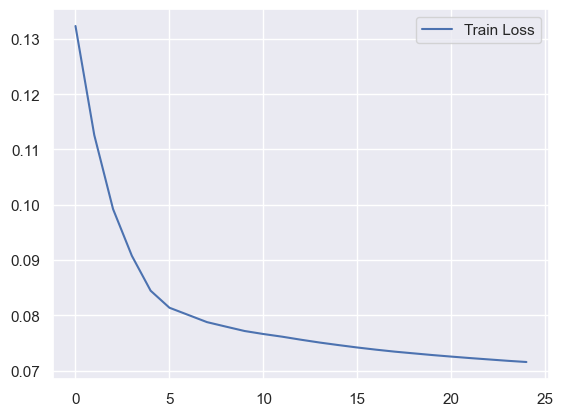

  1/364 [..............................] - ETA: 1:51

2023-07-02 22:37:46.679343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:37:46.742605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


364/364 [==============================] - 1s 2ms/step
Running pipeline for target variable: f3_target_clsf
Index(['share_events_12', 'past6', 'past120', 'cluster_3',
       'event_share_10_stock', 'share_events_6', 'event_share_1_stock',
       'event_share_8_stock', 'share_events_18', 'Adm1_Median',
       'event_share_19_stock', 'refugees_out', 'month', 'event_share_17_stock',
       'year', 'share_events_5', 'num_regions', 'share_onesided_deaths',
       'share_events_gov', 'norm_total_events', 'event_share_6_stock',
       'cluster_1', 'past12', 'share_events_3', 'share_events_15',
       'event_share_15_stock', 'refugees_in', 'neighbor_conflict',
       'share_events_20', 'month_sin', 'share_events_9', 'event_share_4_stock',
       'cluster_2', 'cluster_0', 'share_nonstate_deaths', 'month_cos',
       'event_share_2_stock', 'Adm1_Mean', 'event_share_14_stock',
       'armedconf_since', 'country', 'share_civilian_deaths', 'share_events_2',
       'share_state_deaths', 'share_event

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-02 22:37:50.315101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:37:50.569016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:37:50.908084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

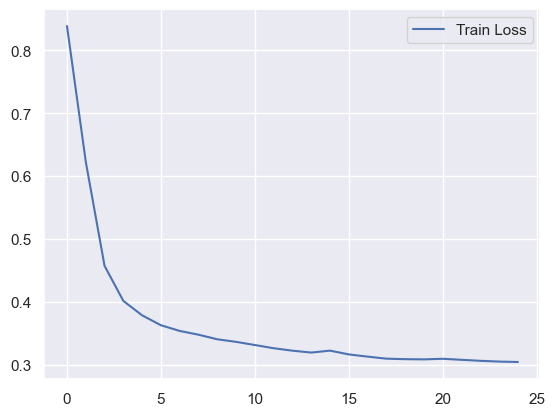

2023-07-02 22:39:47.849345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:39:47.924668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


364/364 [==============================] - 2s 5ms/step
Index(['share_events_12', 'share_events_10', 'event_share_9_stock',
       'share_events_4', 'cluster_3', 'event_share_10_stock', 'share_events_7',
       'share_events_6', 'share_events_8', 'event_share_1_stock',
       'event_share_8_stock', 'share_events_18', 'Adm1_Max',
       'event_share_19_stock', 'event_share_7_stock', 'event_share_17_stock',
       'Adm1_Median', 'event_share_18_stock', 'month', 'share_events_5',
       'year', 'num_regions', 'share_events_gov', 'norm_total_events',
       'event_share_6_stock', 'share_events_16', 'event_share_5_stock',
       'cluster_1', 'share_events_13', 'share_events_3', 'share_events_15',
       'event_share_15_stock', 'share_events_20', 'month_sin',
       'share_events_17', 'share_events_9', 'event_share_4_stock', 'cluster_2',
       'share_events_11', 'share_events_19', 'cluster_0',
       'event_share_20_stock', 'month_cos', 'share_events_1',
       'event_share_2_stock', 'event_

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-02 22:39:52.277292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:39:52.502228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:39:52.957971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

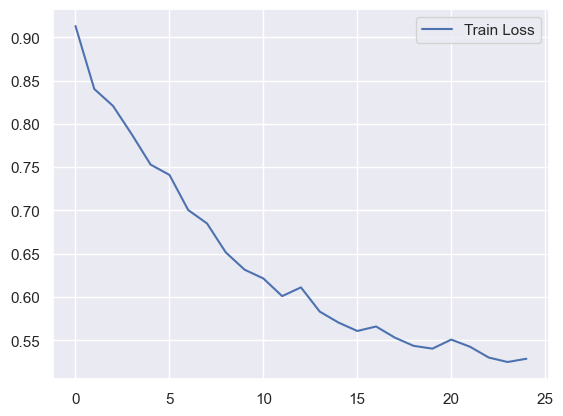

2023-07-02 22:41:45.361904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:41:45.426828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


364/364 [==============================] - 2s 4ms/step
Index(['past6', 'past120', 'deaths_stock', 'refugees_out', 'month', 'year',
       'share_onesided_deaths', 'past12', 'deaths_all_pc', 'refugees_in',
       'neighbor_conflict', 'escalation', 'month_sin', 'past60',
       'share_nonstate_deaths', 'month_cos', 'armedconf', 'armedconf_since',
       'country', 'share_civilian_deaths', 'share_state_deaths',
       'f3_target_clsf', 'isocode'],
      dtype='object')
isocode  year  month
AFG      2000  1        NaN
               2        1.0
               3        1.0
               4        1.0
               5        1.0
                       ... 
ZWE      2017  8        0.0
               9        0.0
               10       0.0
               11       0.0
               12       0.0
Name: f3_target_clsf, Length: 42504, dtype: float64
                    var1(t-1)  var2(t-1)     var3(t-1)  var4(t-1)  var5(t-1)  \
isocode year month                                                  

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-02 22:41:48.290706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:41:48.678587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:41:49.163078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

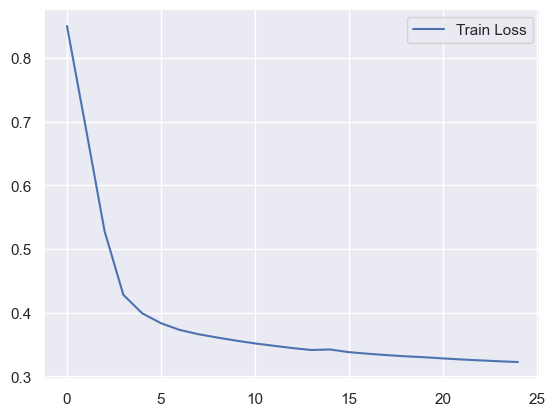

2023-07-02 22:43:33.208838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:43:33.261880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


364/364 [==============================] - 1s 2ms/step
Running pipeline for target variable: f6_target_clsf
Index(['share_events_12', 'past6', 'past120', 'cluster_3',
       'event_share_10_stock', 'share_events_6', 'event_share_1_stock',
       'event_share_8_stock', 'share_events_18', 'Adm1_Median',
       'event_share_19_stock', 'refugees_out', 'month', 'event_share_17_stock',
       'year', 'share_events_5', 'num_regions', 'share_onesided_deaths',
       'share_events_gov', 'norm_total_events', 'event_share_6_stock',
       'cluster_1', 'past12', 'share_events_3', 'share_events_15',
       'event_share_15_stock', 'refugees_in', 'neighbor_conflict',
       'share_events_20', 'month_sin', 'share_events_9', 'event_share_4_stock',
       'cluster_2', 'cluster_0', 'share_nonstate_deaths', 'month_cos',
       'event_share_2_stock', 'Adm1_Mean', 'event_share_14_stock',
       'armedconf_since', 'country', 'share_civilian_deaths', 'share_events_2',
       'share_state_deaths', 'share_event

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-02 22:43:36.282916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:43:36.624114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:43:37.256918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

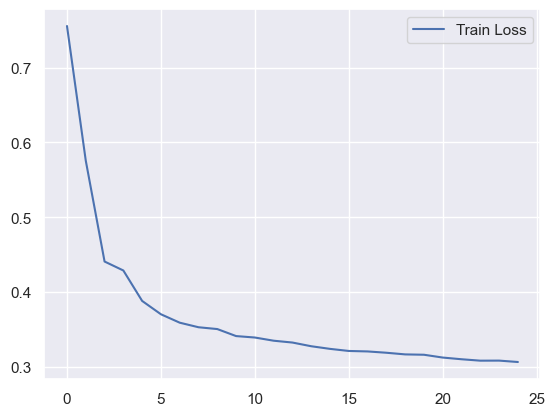

2023-07-02 22:45:31.119059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:45:31.187669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


345/345 [==============================] - 1s 3ms/step
Index(['share_events_12', 'share_events_10', 'event_share_9_stock',
       'share_events_4', 'cluster_3', 'event_share_10_stock', 'share_events_7',
       'share_events_6', 'share_events_8', 'event_share_1_stock',
       'event_share_8_stock', 'share_events_18', 'Adm1_Max',
       'event_share_19_stock', 'event_share_7_stock', 'event_share_17_stock',
       'Adm1_Median', 'event_share_18_stock', 'month', 'share_events_5',
       'year', 'num_regions', 'share_events_gov', 'norm_total_events',
       'event_share_6_stock', 'share_events_16', 'event_share_5_stock',
       'cluster_1', 'share_events_13', 'share_events_3', 'share_events_15',
       'event_share_15_stock', 'share_events_20', 'month_sin',
       'share_events_17', 'share_events_9', 'event_share_4_stock', 'cluster_2',
       'share_events_11', 'share_events_19', 'cluster_0',
       'event_share_20_stock', 'month_cos', 'share_events_1',
       'event_share_2_stock', 'event_

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-02 22:45:34.408833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:45:34.644163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:45:35.097249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

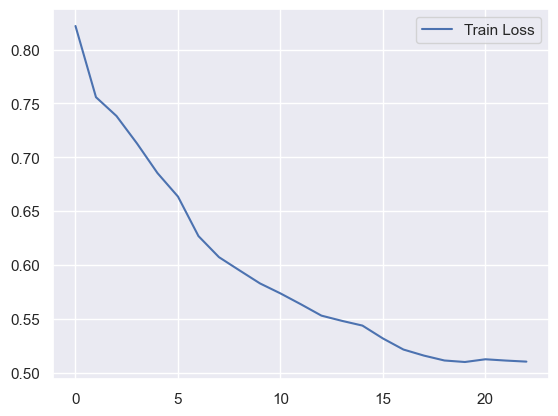

2023-07-02 22:47:17.600717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:47:17.663437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


345/345 [==============================] - 2s 4ms/step
Index(['past6', 'past120', 'deaths_stock', 'refugees_out', 'month', 'year',
       'share_onesided_deaths', 'past12', 'deaths_all_pc', 'refugees_in',
       'neighbor_conflict', 'escalation', 'month_sin', 'past60',
       'share_nonstate_deaths', 'month_cos', 'armedconf', 'armedconf_since',
       'country', 'share_civilian_deaths', 'share_state_deaths',
       'f6_target_clsf', 'isocode'],
      dtype='object')
isocode  year  month
AFG      2000  1        NaN
               2        1.0
               3        1.0
               4        1.0
               5        1.0
                       ... 
ZWE      2017  8        0.0
               9        0.0
               10       0.0
               11       0.0
               12       0.0
Name: f6_target_clsf, Length: 42504, dtype: float64
                    var1(t-1)  var2(t-1)     var3(t-1)  var4(t-1)  var5(t-1)  \
isocode year month                                                  

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-02 22:47:21.087488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:47:21.327622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:47:21.793110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

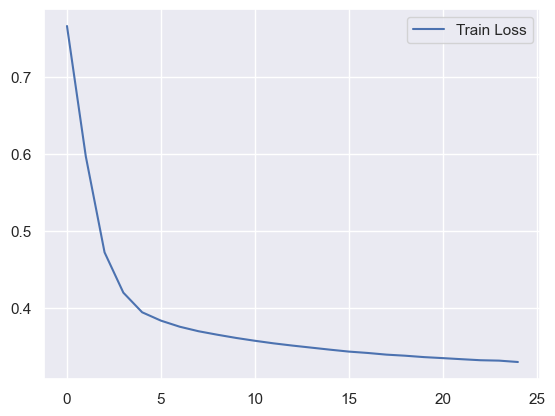

  1/345 [..............................] - ETA: 2:40

2023-07-02 22:49:17.655282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:49:17.716852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


345/345 [==============================] - 1s 3ms/step
Running pipeline for target variable: escalation
Index(['share_events_12', 'past6', 'past120', 'cluster_3',
       'event_share_10_stock', 'share_events_6', 'event_share_1_stock',
       'event_share_8_stock', 'share_events_18', 'Adm1_Median',
       'event_share_19_stock', 'refugees_out', 'month', 'event_share_17_stock',
       'year', 'share_events_5', 'num_regions', 'share_onesided_deaths',
       'share_events_gov', 'norm_total_events', 'event_share_6_stock',
       'cluster_1', 'past12', 'share_events_3', 'share_events_15',
       'event_share_15_stock', 'refugees_in', 'neighbor_conflict',
       'share_events_20', 'month_sin', 'share_events_9', 'event_share_4_stock',
       'cluster_2', 'cluster_0', 'share_nonstate_deaths', 'month_cos',
       'event_share_2_stock', 'Adm1_Mean', 'event_share_14_stock',
       'armedconf_since', 'country', 'share_civilian_deaths', 'share_events_2',
       'share_state_deaths', 'share_events_op

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-02 22:49:20.507889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:49:20.729112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:49:21.141059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

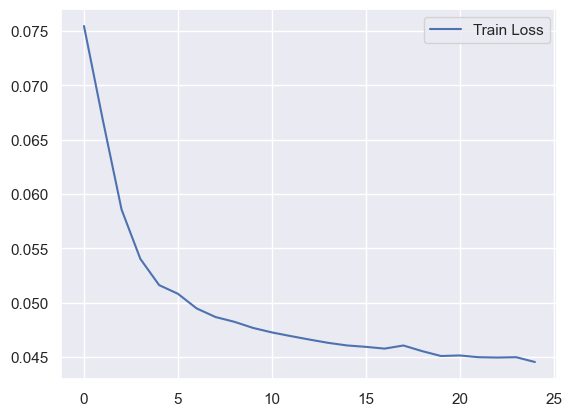

2023-07-02 22:51:11.789784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:51:11.856873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - 2s 3ms/step
Index(['share_events_12', 'share_events_10', 'event_share_9_stock',
       'share_events_4', 'cluster_3', 'event_share_10_stock', 'share_events_7',
       'share_events_6', 'share_events_8', 'event_share_1_stock',
       'event_share_8_stock', 'share_events_18', 'Adm1_Max',
       'event_share_19_stock', 'event_share_7_stock', 'event_share_17_stock',
       'Adm1_Median', 'event_share_18_stock', 'month', 'share_events_5',
       'year', 'num_regions', 'share_events_gov', 'norm_total_events',
       'event_share_6_stock', 'share_events_16', 'event_share_5_stock',
       'cluster_1', 'share_events_13', 'share_events_3', 'share_events_15',
       'event_share_15_stock', 'share_events_20', 'month_sin',
       'share_events_17', 'share_events_9', 'event_share_4_stock', 'cluster_2',
       'share_events_11', 'share_events_19', 'cluster_0',
       'event_share_20_stock', 'month_cos', 'share_events_1',
       'event_share_2_stock', 'event_

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-02 22:51:15.262499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:51:15.489265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:51:16.100641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

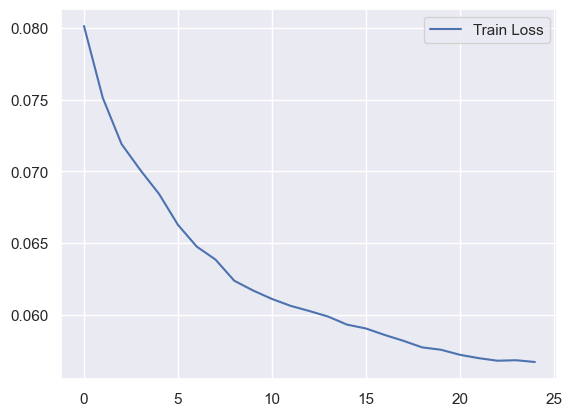

  1/376 [..............................] - ETA: 1:59

2023-07-02 22:53:26.170853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:53:26.233072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - 1s 3ms/step
Index(['past6', 'past120', 'deaths_stock', 'refugees_out', 'month', 'year',
       'share_onesided_deaths', 'past12', 'deaths_all_pc', 'refugees_in',
       'neighbor_conflict', 'escalation', 'month_sin', 'past60',
       'share_nonstate_deaths', 'month_cos', 'armedconf', 'armedconf_since',
       'country', 'share_civilian_deaths', 'share_state_deaths', 'isocode'],
      dtype='object')
isocode  year  month
AFG      2000  1        0
               2        1
               3        0
               4        0
               5        0
                       ..
ZWE      2017  8        0
               9        0
               10       0
               11       0
               12       0
Name: escalation, Length: 42504, dtype: int64
                    var1(t-1)  var2(t-1)     var3(t-1)  var4(t-1)  var5(t-1)  \
isocode year month                                                             
AFG     2000 2       0.001456   0.000198 

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-02 22:53:29.013888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:53:29.212160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:53:29.637578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

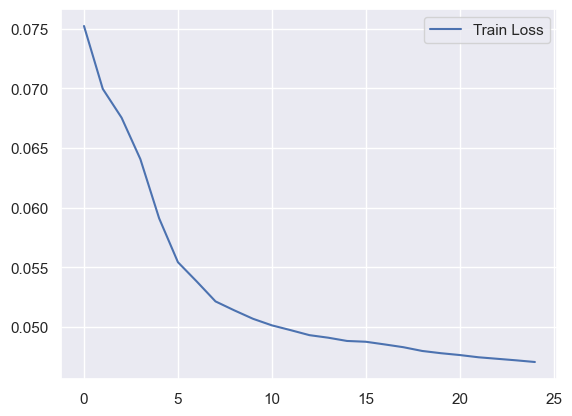

2023-07-02 22:55:35.308881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:55:35.367090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - 2s 3ms/step
Running pipeline for target variable: armedconf
Index(['share_events_12', 'past6', 'past120', 'cluster_3',
       'event_share_10_stock', 'share_events_6', 'event_share_1_stock',
       'event_share_8_stock', 'share_events_18', 'Adm1_Median',
       'event_share_19_stock', 'refugees_out', 'month', 'event_share_17_stock',
       'year', 'share_events_5', 'num_regions', 'share_onesided_deaths',
       'share_events_gov', 'norm_total_events', 'event_share_6_stock',
       'cluster_1', 'past12', 'share_events_3', 'share_events_15',
       'event_share_15_stock', 'refugees_in', 'neighbor_conflict',
       'share_events_20', 'month_sin', 'share_events_9', 'event_share_4_stock',
       'cluster_2', 'cluster_0', 'share_nonstate_deaths', 'month_cos',
       'event_share_2_stock', 'Adm1_Mean', 'event_share_14_stock',
       'armedconf_since', 'country', 'share_civilian_deaths', 'share_events_2',
       'share_state_deaths', 'share_events_opp

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-02 22:55:38.484861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:55:38.799374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:55:39.448063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

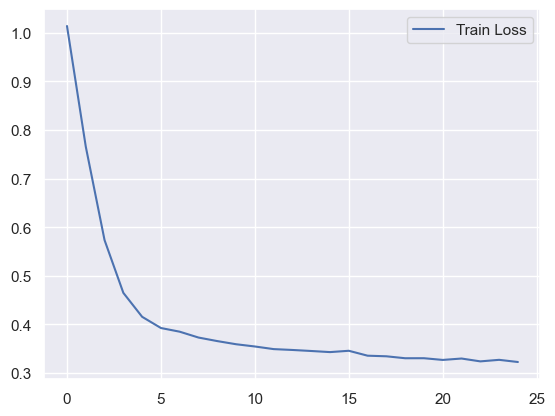

2023-07-02 22:57:42.620568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:57:42.678486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - 1s 3ms/step
Index(['share_events_12', 'share_events_10', 'event_share_9_stock',
       'share_events_4', 'cluster_3', 'event_share_10_stock', 'share_events_7',
       'share_events_6', 'share_events_8', 'event_share_1_stock',
       'event_share_8_stock', 'share_events_18', 'Adm1_Max',
       'event_share_19_stock', 'event_share_7_stock', 'event_share_17_stock',
       'Adm1_Median', 'event_share_18_stock', 'month', 'share_events_5',
       'year', 'num_regions', 'share_events_gov', 'norm_total_events',
       'event_share_6_stock', 'share_events_16', 'event_share_5_stock',
       'cluster_1', 'share_events_13', 'share_events_3', 'share_events_15',
       'event_share_15_stock', 'share_events_20', 'month_sin',
       'share_events_17', 'share_events_9', 'event_share_4_stock', 'cluster_2',
       'share_events_11', 'share_events_19', 'cluster_0',
       'event_share_20_stock', 'month_cos', 'share_events_1',
       'event_share_2_stock', 'event_

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-02 22:57:45.846010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:57:46.043693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:57:46.653586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

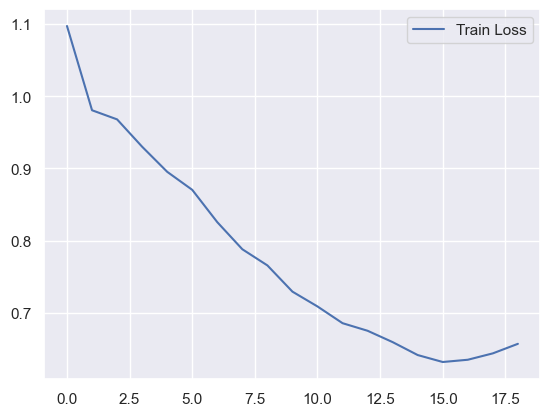

2023-07-02 22:59:23.329118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:59:23.397654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - 2s 4ms/step
Index(['past6', 'past120', 'deaths_stock', 'refugees_out', 'month', 'year',
       'share_onesided_deaths', 'past12', 'deaths_all_pc', 'refugees_in',
       'neighbor_conflict', 'escalation', 'month_sin', 'past60',
       'share_nonstate_deaths', 'month_cos', 'armedconf', 'armedconf_since',
       'country', 'share_civilian_deaths', 'share_state_deaths', 'isocode'],
      dtype='object')
isocode  year  month
AFG      2000  1        1
               2        1
               3        1
               4        1
               5        1
                       ..
ZWE      2017  8        0
               9        0
               10       0
               11       0
               12       0
Name: armedconf, Length: 42504, dtype: int64
                    var1(t-1)  var2(t-1)     var3(t-1)  var4(t-1)  var5(t-1)  \
isocode year month                                                             
AFG     2000 2       0.001456   0.000198  

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-02 22:59:26.854967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:59:27.147373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 22:59:28.096663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

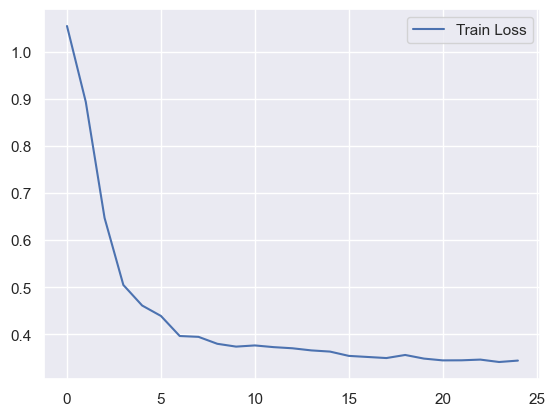

2023-07-02 23:01:25.008015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 23:01:25.090289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - 2s 4ms/step


In [105]:
target_variables = ['f6_target_escl','f3_target_escl', 'f3_target_clsf',
                    'f6_target_clsf', 'escalation', 'armedconf']


for target in target_variables:
    print(f"Running pipeline for target variable: {target}")
    
    result, encoder, reframed_train, reframed_test_comb, sc_comb_test = run_pipeline(df_final, target, combination_vars, 2018, False)

    all_results.append({
        'target': target,
        'variables': 'combined_vars',
        'reframed_test' : reframed_test_comb,
        'y_pred': result['y_pred'],
        'y_test': result['y_test'],
        'accuracy': result['accuracy'],
        'recall': result['recall'],
        'precision': result['precision'],
        'trained_model': result['model'],
        'report': result['report']
    })
    
    result, _, _, reframed_test_gdelt, _ = run_pipeline(df_final, target, text_gdelt_vars, 2018, True)
    all_results.append({
        'target': target,
        'variables': 'text_gdelt_vars',
        'reframed_test' : reframed_test_gdelt,
        'y_pred': result['y_pred'],
        'y_test': result['y_test'],
        'accuracy': result['accuracy'],
        'recall': result['recall'],
        'precision': result['precision'],
        'trained_model': result['model'],
        'report': result['report']
    })
    
    result, _, _, reframed_test_hist, _ = run_pipeline(df_final, target, historical_vars, 2018, False)
    all_results.append({
        'target': target,
        'variables': 'historical_vars',
        'reframed_test' : reframed_test_hist,
        'y_pred': result['y_pred'],
        'y_test': result['y_test'],
        'accuracy': result['accuracy'],
        'recall': result['recall'],
        'precision': result['precision'],
        'trained_model': result['model'],
        'report': result['report']
    })

In [106]:
from keras.models import save_model

for i, result in enumerate(all_results):
    save_model(result['trained_model'], f"lstm_saved_models/model_{i}.h5")


In [107]:
import pickle

with open('lstm_saved_models/all_results_classifier.pkl', 'wb') as f:
    pickle.dump(all_results, f)


INFO:tensorflow:Assets written to: ram://bbf2aa33-15f7-4c11-baac-b2ab7d38ad47/assets


INFO:tensorflow:Assets written to: ram://bbf2aa33-15f7-4c11-baac-b2ab7d38ad47/assets


INFO:tensorflow:Assets written to: ram://5113873d-36f6-4c09-9ff1-e2b6865aaa77/assets


INFO:tensorflow:Assets written to: ram://5113873d-36f6-4c09-9ff1-e2b6865aaa77/assets


INFO:tensorflow:Assets written to: ram://b400b5dc-7227-469b-9c6f-607ec50b1999/assets


INFO:tensorflow:Assets written to: ram://b400b5dc-7227-469b-9c6f-607ec50b1999/assets


INFO:tensorflow:Assets written to: ram://fb7a330a-e23f-465e-9cca-9096bd2a00d7/assets


INFO:tensorflow:Assets written to: ram://fb7a330a-e23f-465e-9cca-9096bd2a00d7/assets


INFO:tensorflow:Assets written to: ram://acee8a0a-2970-4f2f-82c1-25f111d853a8/assets


INFO:tensorflow:Assets written to: ram://acee8a0a-2970-4f2f-82c1-25f111d853a8/assets


INFO:tensorflow:Assets written to: ram://fc318576-efdf-4036-a56d-9140b16bc1fd/assets


INFO:tensorflow:Assets written to: ram://fc318576-efdf-4036-a56d-9140b16bc1fd/assets


INFO:tensorflow:Assets written to: ram://a2668bf3-af40-447e-a7f4-c5a0068f2ff6/assets


INFO:tensorflow:Assets written to: ram://a2668bf3-af40-447e-a7f4-c5a0068f2ff6/assets


INFO:tensorflow:Assets written to: ram://aaf3e9d3-cf7e-4789-926f-ed3af85a7961/assets


INFO:tensorflow:Assets written to: ram://aaf3e9d3-cf7e-4789-926f-ed3af85a7961/assets


INFO:tensorflow:Assets written to: ram://4c354706-9b7c-4061-9ad6-e929bdd29e63/assets


INFO:tensorflow:Assets written to: ram://4c354706-9b7c-4061-9ad6-e929bdd29e63/assets


INFO:tensorflow:Assets written to: ram://5d3e4fe6-b745-47af-80fe-289b6be973ba/assets


INFO:tensorflow:Assets written to: ram://5d3e4fe6-b745-47af-80fe-289b6be973ba/assets


INFO:tensorflow:Assets written to: ram://5cb29698-46df-4658-b869-0c2078b78da6/assets


INFO:tensorflow:Assets written to: ram://5cb29698-46df-4658-b869-0c2078b78da6/assets


INFO:tensorflow:Assets written to: ram://005c620e-a62e-4f97-915d-93f819b7ecaf/assets


INFO:tensorflow:Assets written to: ram://005c620e-a62e-4f97-915d-93f819b7ecaf/assets


INFO:tensorflow:Assets written to: ram://d2b0f139-129d-4b9a-907a-03f3b069d46f/assets


INFO:tensorflow:Assets written to: ram://d2b0f139-129d-4b9a-907a-03f3b069d46f/assets


INFO:tensorflow:Assets written to: ram://6254e90e-1c1b-434c-b535-66f11f9d0ef3/assets


INFO:tensorflow:Assets written to: ram://6254e90e-1c1b-434c-b535-66f11f9d0ef3/assets


INFO:tensorflow:Assets written to: ram://cd018f02-cd4b-463e-be6e-afbe5ab5bdfb/assets


INFO:tensorflow:Assets written to: ram://cd018f02-cd4b-463e-be6e-afbe5ab5bdfb/assets


INFO:tensorflow:Assets written to: ram://05796c4b-bbdb-43ae-8d6c-4cb964d19e34/assets


INFO:tensorflow:Assets written to: ram://05796c4b-bbdb-43ae-8d6c-4cb964d19e34/assets


INFO:tensorflow:Assets written to: ram://fdf6000f-2aba-47fd-845b-95ed97feca1c/assets


INFO:tensorflow:Assets written to: ram://fdf6000f-2aba-47fd-845b-95ed97feca1c/assets


INFO:tensorflow:Assets written to: ram://8bcc6d89-37d6-471c-bc8a-ed4076b72d71/assets


INFO:tensorflow:Assets written to: ram://8bcc6d89-37d6-471c-bc8a-ed4076b72d71/assets


In [108]:
targets_t1 = ['armedconf', 'escalation']
targets_t3 = ['f3_target_escl', 'f3_target_clsf']
targets_t6 = ['f6_target_escl', 'f6_target_clsf' ]

In [109]:
# Initialize dictionaries to store the final DataFrames for each target
final_dfs_t1 = {}
final_dfs_t3 = {}
final_dfs_t6 = {}

# Iterate over all results
for result in all_results:
    target = result['target']
    reframed_test = result['reframed_test']
    variables = result['variables']

    # Create a DataFrame for the target using the index from reframed_test
    final_df = pd.DataFrame(index=reframed_test.index)

    # Add true value columns
    true_values = result['y_test'].flatten()
    final_df[f"{target}_true"] = true_values

    # Add predicted value columns
    predictions_shifted = pd.Series(result['y_pred'].flatten())
    final_df[f"{target}_{variables}_pred"] = predictions_shifted.values

    # Drop rows with NaN values
    final_df.dropna(inplace=True)

    # Use a tuple of target and variables as the key in the dictionary
    key = (target, variables)

    # Store the final DataFrame for the target in the corresponding dictionary
    if target in targets_t1:
        final_dfs_t1[key] = final_df
    elif target in targets_t3:
        final_dfs_t3[key] = final_df
    elif target in targets_t6:
        final_dfs_t6[key] = final_df



In [113]:
final_dfs_t1

{('escalation',
  'combined_vars'):                     escalation_true  escalation_combined_vars_pred
 isocode year month                                                
 AFG     2018 2                  0.0                       0.481359
              3                  1.0                       0.450832
              4                  1.0                       0.361613
              5                  0.0                       0.385717
              6                  1.0                       0.452312
 ...                             ...                            ...
 ZWE     2022 10                 0.0                       0.152972
              11                 0.0                       0.153735
              12                 0.0                       0.153437
         2023 1                  0.0                       0.153957
              2                  0.0                       0.144052
 
 [12017 rows x 2 columns],
 ('escalation',
  'text_gdelt_vars'):               

In [125]:
def combine_predictions(targets, methods, df_dict, output_file):
    """
    Combine 'true' and 'pred' values for each target and method into a single DataFrame.

    Args:
    targets (list): List of target variables.
    methods (list): List of methods.
    df_dict (dict): Dictionary of DataFrames.
    output_file (str): Output CSV file name.

    Returns:
    None.
    """

    # Create an empty DataFrame
    result_df = pd.DataFrame()

    # Iterate over targets
    for target in targets:
        # Flag to check if the true values of a target have been added
        added_true_values = False
        # Iterate over methods
        for method in methods:
            # Check if the DataFrame exists in df_dict
            if (target, method) in df_dict:
                # Get the DataFrame from df_dict
                df = df_dict[(target, method)]
        
                # If the true values of the target have not been added, initialize it with the 'true' column
                if not added_true_values:
                    result_df[f"{target}_true"] = df[f"{target}_true"]
                    added_true_values = True  # Update the flag
        
                # Add the 'pred' column
                result_df[f"{target}_{method}_pred"] = df[f"{target}_{method}_pred"]

    # Save the DataFrame to a CSV file
    result_df.to_csv(output_file)

    print(f"File saved as {output_file}")


In [126]:
methods = ["combined_vars", "text_gdelt_vars", "historical_vars"]
output_file = 'lstm_metrics_pred/predictions_combined_clsf_f1.csv'

combine_predictions(targets_t1, methods, final_dfs_t1, output_file)

File saved as lstm_metrics_pred/predictions_combined_clsf_f1.csv


In [127]:
combine_predictions(targets_t3, methods, final_dfs_t3, 'lstm_metrics_pred/predictions_combined_clsf_f3.csv')

File saved as lstm_metrics_pred/predictions_combined_clsf_f3.csv


In [128]:
combine_predictions(targets_t6, methods, final_dfs_t6, 'lstm_metrics_pred/predictions_combined_clsf_f6.csv')

File saved as lstm_metrics_pred/predictions_combined_clsf_f6.csv


In [129]:
test_data_copy = sc_comb_test.copy()

## Interpretation

In [135]:
# Sorting by year, month, and isocode
final_df_sorted = final_dfs_t1[('escalation', 'combined_vars')]

y_pred = final_df_sorted['escalation_combined_vars_pred']
y_test = final_df_sorted['escalation_true']

print(len(y_pred), len(y_test))

# Use the same index as in final_df_sorted
index = final_df_sorted.index
pa = pd.DataFrame(index=index)

pa['Prediction'] = y_pred
pa['Actual Values'] = y_test
pa.head()


12017 12017


Prediction  Actual Values
isocode year month                           
AFG     2018 2        0.481359            0.0
             3        0.450832            1.0
             4        0.361613            1.0
             5        0.385717            0.0
             6        0.452312            1.0

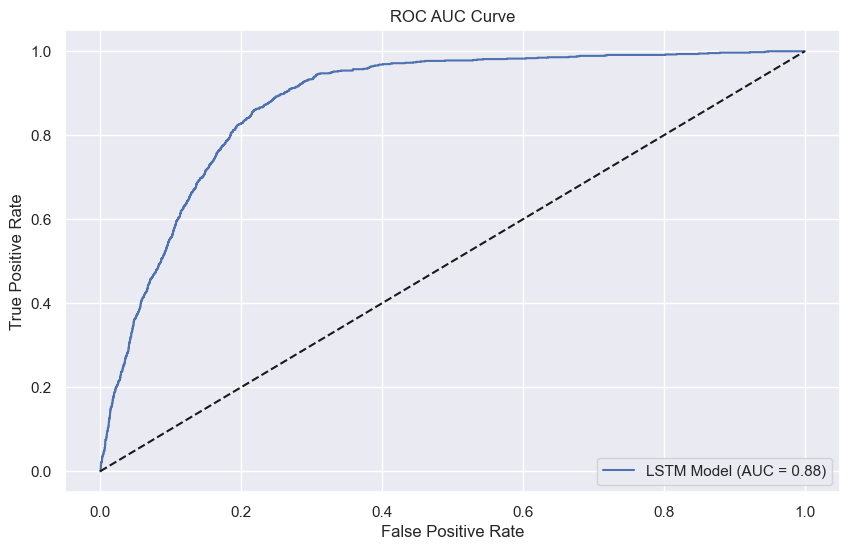

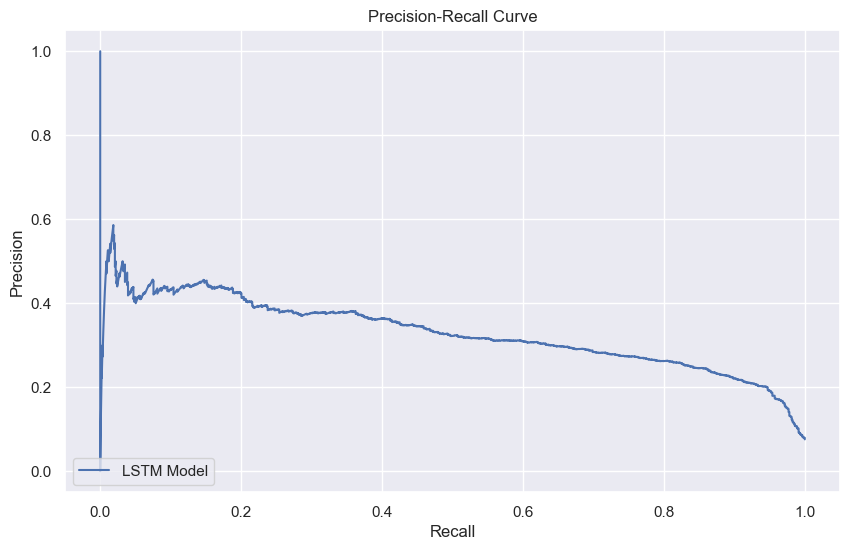

In [143]:
y_true = pa['Actual Values'].values
y_pred = pa['Prediction'].values


# calculate ROC AUC score
roc_auc = roc_auc_score(y_true, y_pred)

# calculate Precision and Recall scores
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# plot ROC AUC curve
plt.figure(figsize=(10, 6))
plt.plot(*roc_curve(y_true, y_pred)[:2], label='LSTM Model (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='LSTM Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


Metrics

In [144]:
# classes
y_pred_classes = (pa['Prediction'].values > 0.5).astype(int)

print("Confusion Matrix:\n", confusion_matrix(pa['Actual Values'].values, y_pred_classes))

print("\nClassification Report:\n", classification_report(pa['Actual Values'].values, y_pred_classes))

roc_auc_minority = roc_auc_score(pa['Actual Values'].values == 1, y_pred_classes)
print("\nROC AUC for minority class:", roc_auc_minority)

Confusion Matrix:
 [[10213   891]
 [  475   438]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     11104
         1.0       0.33      0.48      0.39       913

    accuracy                           0.89     12017
   macro avg       0.64      0.70      0.66     12017
weighted avg       0.91      0.89      0.90     12017


ROC AUC for minority class: 0.6997478879363406


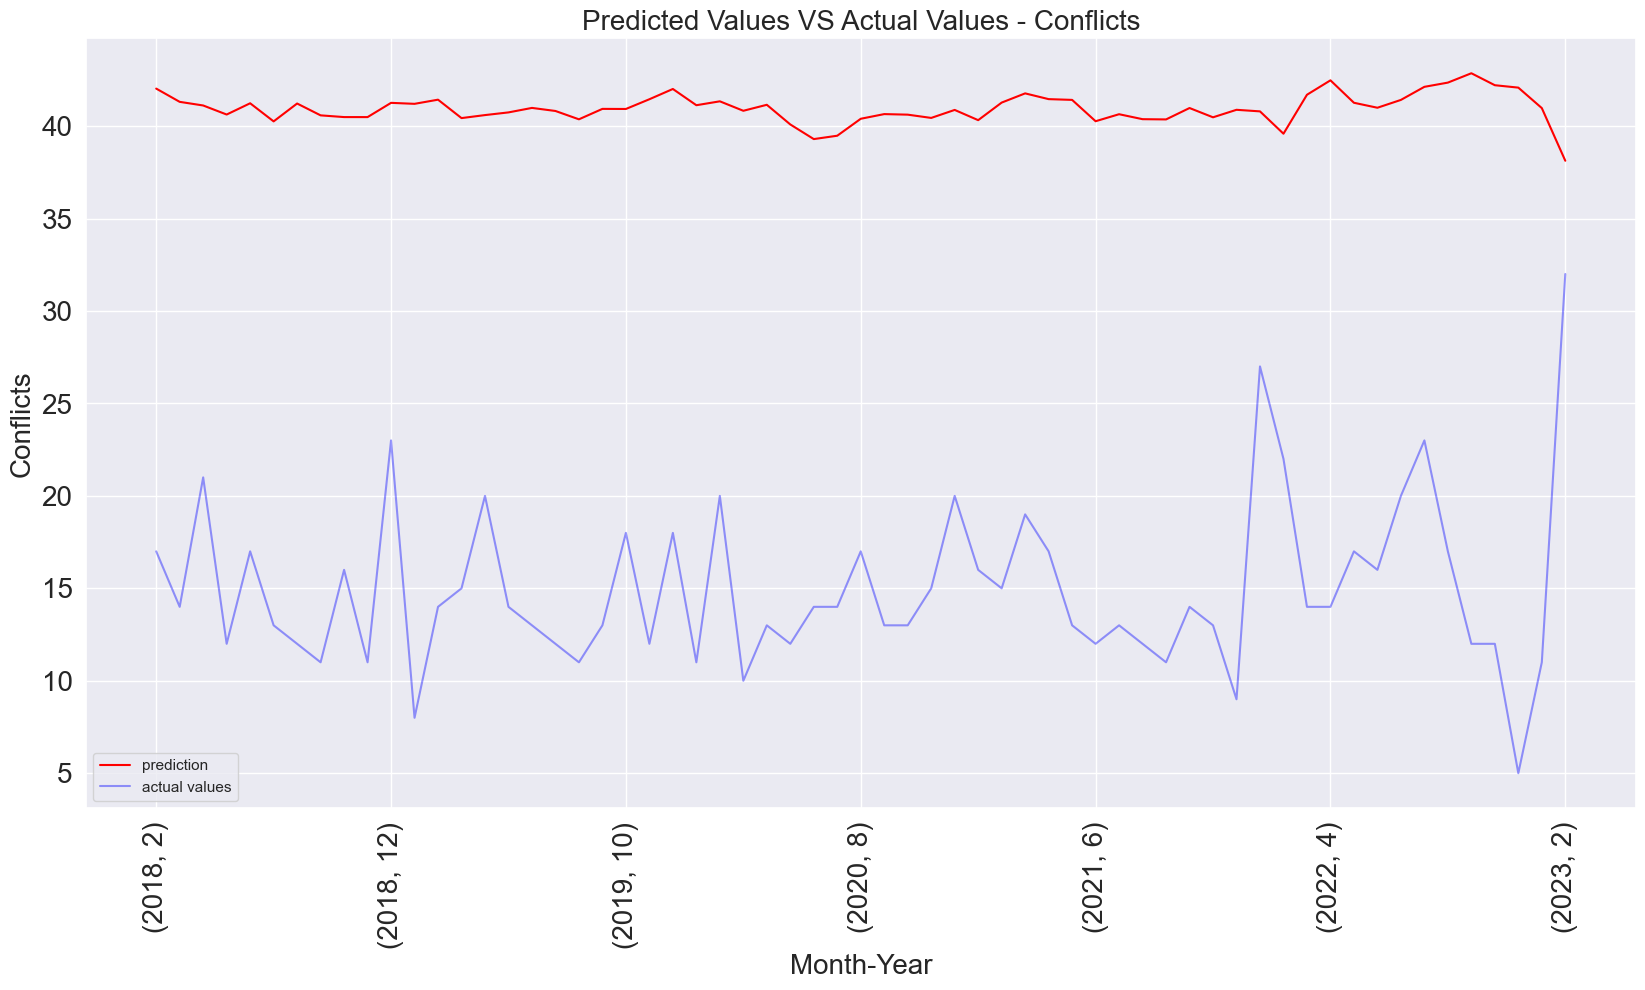

In [145]:
plt.figure(figsize=(20,10))

pa['Prediction'].groupby(level=['year', 'month']).sum().plot(kind='line', label='prediction', color='red', alpha=1)
pa['Actual Values'].groupby(level=['year', 'month']).sum().plot(kind='line', label='actual values', color='blue', alpha=0.4)

plt.xticks(rotation=90, size=20)
plt.yticks(size=20)

plt.ylabel('Conflicts', fontsize=20)
plt.xlabel('Month-Year', fontsize=20)
plt.title('Predicted Values VS Actual Values - Conflicts', fontsize=20)
plt.legend()


In [146]:

metrics_df = pd.DataFrame()

for result in all_results:
    # model name from the 'target' and 'variables' fields
    model_name = f"{result['target']}_{result['variables']}"


    metrics_df.loc[model_name, 'accuracy'] = result['accuracy']
    metrics_df.loc[model_name, 'recall'] = result['recall']
    metrics_df.loc[model_name, 'precision'] = result['precision']

In [147]:
metrics_df

,accuracy,recall,precision
f6_target_escl_combined_vars,0.904732,0.802190,0.822230
f6_target_escl_text_gdelt_vars,0.810823,0.640410,0.629077
f6_target_escl_historical_vars,0.893129,0.771812,0.803900
f3_target_escl_combined_vars,0.879721,0.792541,0.640784
f3_target_escl_text_gdelt_vars,0.838252,0.480186,0.573816
f3_target_escl_historical_vars,0.882044,0.779487,0.650584
f3_target_clsf_combined_vars,0.939258,0.844784,0.741899
f3_target_clsf_text_gdelt_vars,0.900714,0.409669,0.740230
f3_target_clsf_historical_vars,0.943990,0.872137,0.752883
f6_target_clsf_combined_vars,0.932016,0.811161,0.776160


In [148]:
metrics_df.to_csv('lstm_metrics_pred/metrics_classifier.csv')

In [149]:
def get_roc_pr(all_results, target: str, binary=True, plot=True):
    """Function to return the roc and pr values for a given target"""
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    
    for result in all_results:

        if result['target'] != target:
            continue

        y_true = result['y_test']
        y_pred = result['y_pred']
    
        roc = roc_auc_score(y_true, y_pred)
        pr = average_precision_score(y_true, y_pred)
    
        # Compute the FPR & TPR and calculate the AUC
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
    
        # Compute precision, recall, and thresholds for PR curve
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
    
        print('Model:', result['variables'])
        print('ROC:', round(roc, 3), 'Precision:', round(pr, 3))
        
        # Print classification report
        print('\nClassification report:\n', result['report'])
    
        # Plot ROC curve
        axs[0].plot(fpr, tpr, lw=2, label=f'ROC curve {result["variables"]} (area = {roc_auc:.2f})')
    
        # Plot precision-recall curve
        axs[1].plot(recall, precision, lw=2, label=f'Precision-Recall curve {result["variables"]} (prec: {pr:.2f})')
    
    axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlabel('False Positive Rate (FP/(FP+TN))')
    axs[0].set_ylabel('True Positive Rate/Recall (TP/(TP+FN))')
    axs[0].set_title(f'ROCs for {target}')
    axs[0].legend(loc="lower right")
    
    axs[1].set_xlabel('Recall (TP/(TP+FN))')
    axs[1].set_ylabel('Precision (TP/(TP+FP))')
    axs[1].set_title('Precision-Recall Curve')
    axs[1].legend(loc="lower left")
    
    plt.tight_layout()
    plt.show()


Model: combined_vars
ROC: 0.942 Precision: 0.843

Classification report:
               precision    recall  f1-score   support

         0.0       0.93      0.94      0.94      8201
         1.0       0.82      0.80      0.81      2831

    accuracy                           0.90     11032
   macro avg       0.88      0.87      0.87     11032
weighted avg       0.90      0.90      0.90     11032

Model: text_gdelt_vars
ROC: 0.83 Precision: 0.667

Classification report:
               precision    recall  f1-score   support

         0.0       0.88      0.87      0.87      8201
         1.0       0.63      0.64      0.63      2831

    accuracy                           0.81     11032
   macro avg       0.75      0.76      0.75     11032
weighted avg       0.81      0.81      0.81     11032

Model: historical_vars
ROC: 0.937 Precision: 0.83

Classification report:
               precision    recall  f1-score   support

         0.0       0.92      0.94      0.93      8201
         1.0 

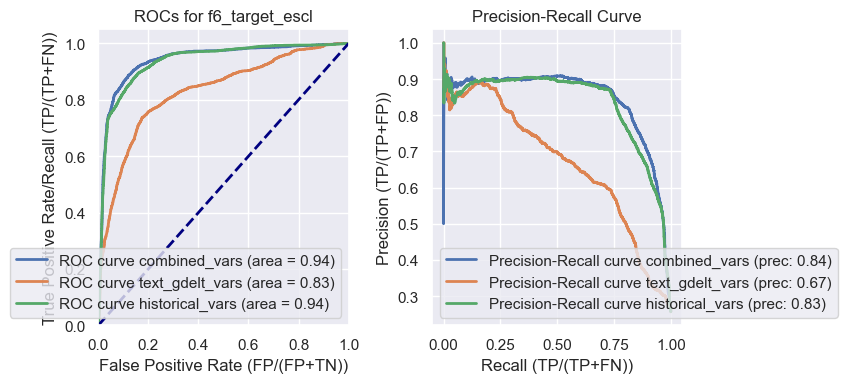

Model: combined_vars
ROC: 0.917 Precision: 0.657

Classification report:
               precision    recall  f1-score   support

         0.0       0.95      0.90      0.92      9478
         1.0       0.64      0.79      0.71      2145

    accuracy                           0.88     11623
   macro avg       0.80      0.85      0.82     11623
weighted avg       0.89      0.88      0.88     11623

Model: text_gdelt_vars
ROC: 0.827 Precision: 0.526

Classification report:
               precision    recall  f1-score   support

         0.0       0.89      0.92      0.90      9478
         1.0       0.57      0.48      0.52      2145

    accuracy                           0.84     11623
   macro avg       0.73      0.70      0.71     11623
weighted avg       0.83      0.84      0.83     11623

Model: historical_vars
ROC: 0.912 Precision: 0.654

Classification report:
               precision    recall  f1-score   support

         0.0       0.95      0.91      0.93      9478
         1.

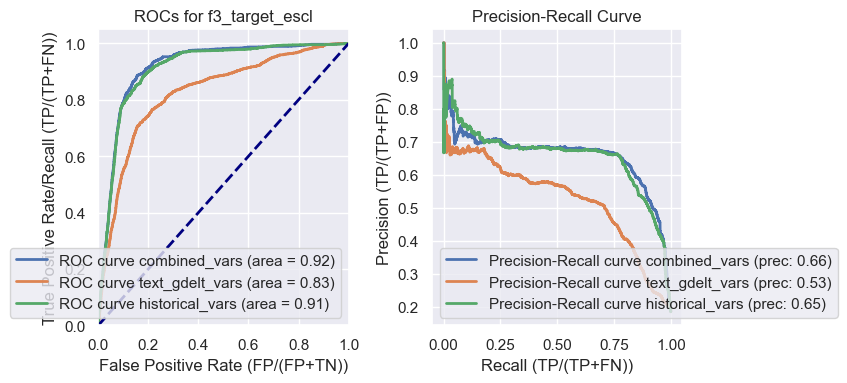

Model: combined_vars
ROC: 0.967 Precision: 0.844

Classification report:
               precision    recall  f1-score   support

         0.0       0.98      0.95      0.96     10051
         1.0       0.74      0.84      0.79      1572

    accuracy                           0.94     11623
   macro avg       0.86      0.90      0.88     11623
weighted avg       0.94      0.94      0.94     11623

Model: text_gdelt_vars
ROC: 0.87 Precision: 0.648

Classification report:
               precision    recall  f1-score   support

         0.0       0.91      0.98      0.94     10051
         1.0       0.74      0.41      0.53      1572

    accuracy                           0.90     11623
   macro avg       0.83      0.69      0.74     11623
weighted avg       0.89      0.90      0.89     11623

Model: historical_vars
ROC: 0.972 Precision: 0.905

Classification report:
               precision    recall  f1-score   support

         0.0       0.98      0.96      0.97     10051
         1.0

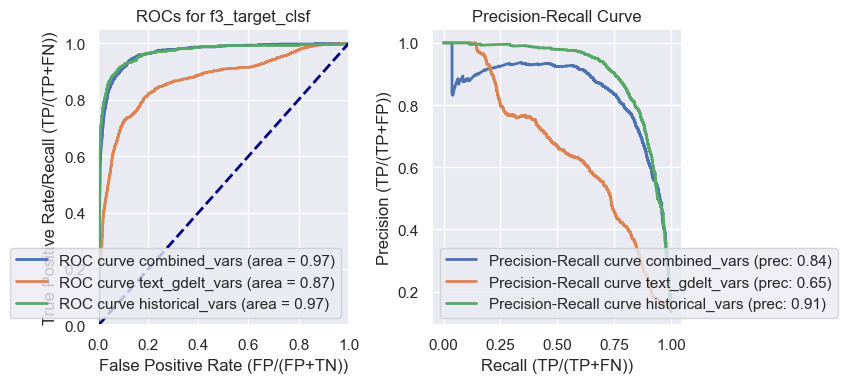

Model: combined_vars
ROC: 0.962 Precision: 0.882

Classification report:
               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      9258
         1.0       0.78      0.81      0.79      1774

    accuracy                           0.93     11032
   macro avg       0.87      0.88      0.88     11032
weighted avg       0.93      0.93      0.93     11032

Model: text_gdelt_vars
ROC: 0.844 Precision: 0.656

Classification report:
               precision    recall  f1-score   support

         0.0       0.91      0.95      0.93      9258
         1.0       0.67      0.53      0.59      1774

    accuracy                           0.88     11032
   macro avg       0.79      0.74      0.76     11032
weighted avg       0.88      0.88      0.88     11032

Model: historical_vars
ROC: 0.962 Precision: 0.893

Classification report:
               precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      9258
         1.

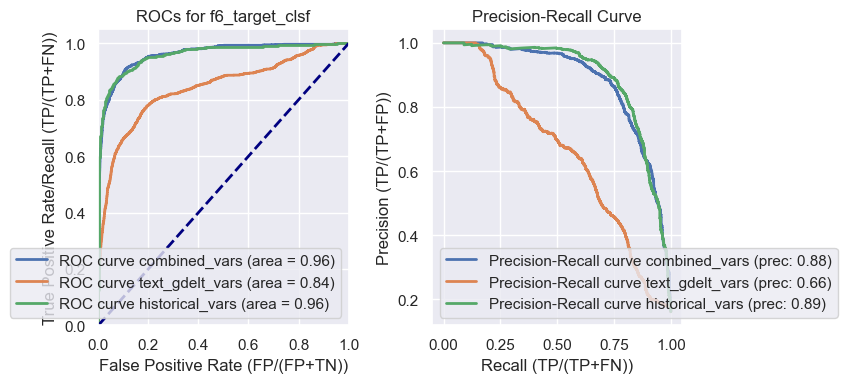

Model: combined_vars
ROC: 0.881 Precision: 0.33

Classification report:
               precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     11104
         1.0       0.33      0.48      0.39       913

    accuracy                           0.89     12017
   macro avg       0.64      0.70      0.66     12017
weighted avg       0.91      0.89      0.90     12017

Model: text_gdelt_vars
ROC: 0.794 Precision: 0.216

Classification report:
               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     11104
         1.0       0.29      0.07      0.11       913

    accuracy                           0.92     12017
   macro avg       0.61      0.53      0.53     12017
weighted avg       0.88      0.92      0.89     12017

Model: historical_vars
ROC: 0.876 Precision: 0.322

Classification report:
               precision    recall  f1-score   support

         0.0       0.97      0.89      0.93     11104
         1.0

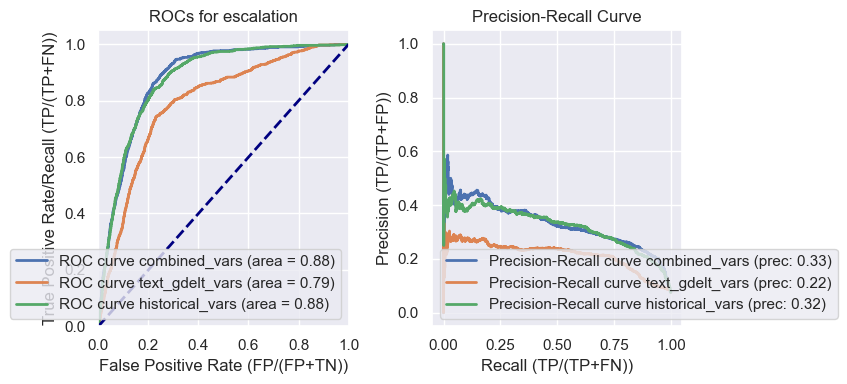

Model: combined_vars
ROC: 0.98 Precision: 0.882

Classification report:
               precision    recall  f1-score   support

         0.0       0.98      0.97      0.97     10780
         1.0       0.74      0.87      0.80      1237

    accuracy                           0.96     12017
   macro avg       0.86      0.92      0.89     12017
weighted avg       0.96      0.96      0.96     12017

Model: text_gdelt_vars
ROC: 0.868 Precision: 0.491

Classification report:
               precision    recall  f1-score   support

         0.0       0.93      0.97      0.95     10780
         1.0       0.59      0.32      0.42      1237

    accuracy                           0.91     12017
   macro avg       0.76      0.65      0.68     12017
weighted avg       0.89      0.91      0.89     12017

Model: historical_vars
ROC: 0.979 Precision: 0.86

Classification report:
               precision    recall  f1-score   support

         0.0       0.99      0.94      0.96     10780
         1.0 

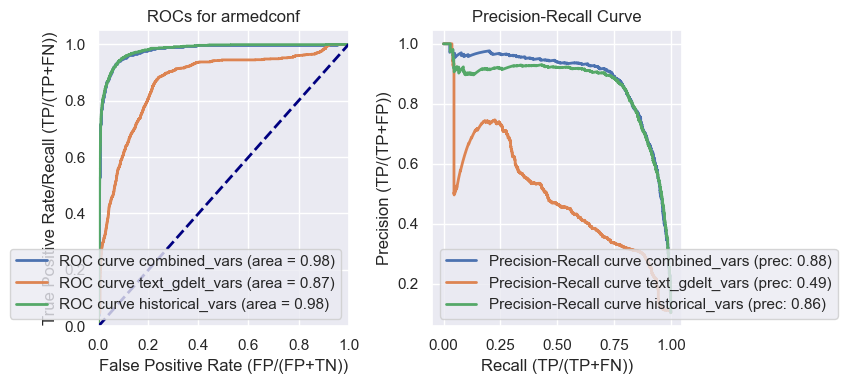

In [152]:
for target in target_variables: 
    get_roc_pr(all_results, target)

Predicting and visualizing only most violent countries. 

Let's predict using the same model but now for a subset of deadliest countries. 

In [ ]:
def get_trained_model(target, variables):
    for result in all_results:
        if result['target'] == target and result['variables'] == variables:
            return result['trained_model']
    return None

model = get_trained_model('armedconf', 'combined_vars')

if model is not None:
    print("Model found!")
    # do something with the model here
else:
    print("No model found for this target and variables combination.")


Model found!


In [153]:
def plot_country_data(df_key, top_10_country_names, shift):
    if df_key in final_dfs_t1:
        final_df = final_dfs_t1[df_key]
    elif df_key in final_dfs_t3:
        final_df = final_dfs_t3[df_key]
    elif df_key in final_dfs_t6:
        final_df = final_dfs_t6[df_key]
    else:
        return "DataFrame not found"

    final_df['country_name'] = final_df.index.get_level_values('isocode').map(get_country_name)

    for country_name in top_10_country_names:
        # Get data for this country
        country_data = final_df[final_df['country_name'] == country_name].copy()

        # Generate predictions and true values
        y_pred = country_data[f"{df_key[0]}_{df_key[1]}_pred"]
        y_test = country_data[f"{df_key[0]}_true"]

        # Shift predictions back by one time step
        y_pred_shifted = y_pred.shift(shift)
        y_pred_binary = (y_pred_shifted > 0.5).astype(int)

        # calculate errors
        precision = precision_score(y_test, y_pred_binary)
        recall = recall_score(y_test, y_pred_binary)


        print('{} - Precision: {}, Recall: {}'.format(country_name, recall, precision))

        pa = pd.DataFrame(index=country_data.index)
        pa['Prediction'] = y_pred_shifted
        pa['Actual Values'] = y_test  # Flatten to get a 1D array for plotting

        # Create 'Date' directly from 'country_data.index'
        pa['Date'] = pd.to_datetime(country_data.index.get_level_values('year').astype(str) + '-' + country_data.index.get_level_values('month').astype(str) + '-01')

        plt.figure(figsize=(20, 10))
        plt.plot(pa['Date'], pa['Prediction'], label='prediction', color='red', alpha=1)
        plt.plot(pa['Date'], pa['Actual Values'], label='actual values', color='blue', alpha=0.4)
        plt.xticks(rotation=90, size=20)
        plt.yticks(size=20)

        plt.ylabel('Deaths', fontsize=20)
        plt.xlabel('Date', fontsize=20)
        plt.title('Predicted Values VS Actual Values - Deaths Per Capita in {}'.format(country_name), fontsize=20)
        plt.legend()
        plt.show()


Afghanistan - Precision: 0.0, Recall: 0.0


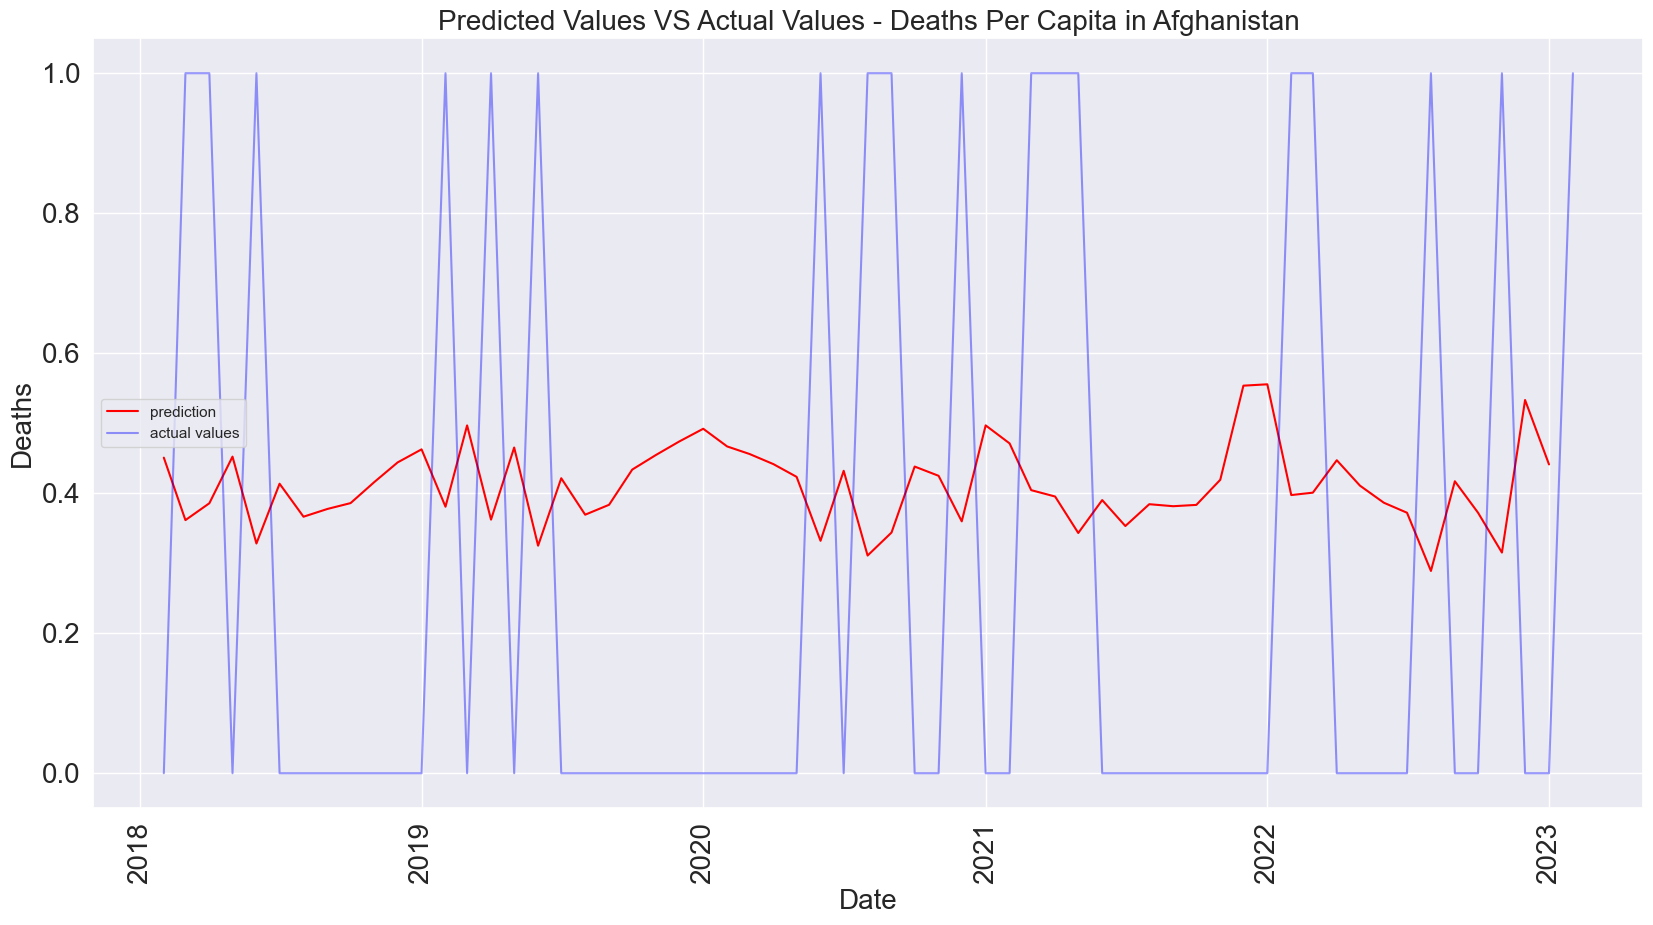

Somalia - Precision: 0.0, Recall: 0.0


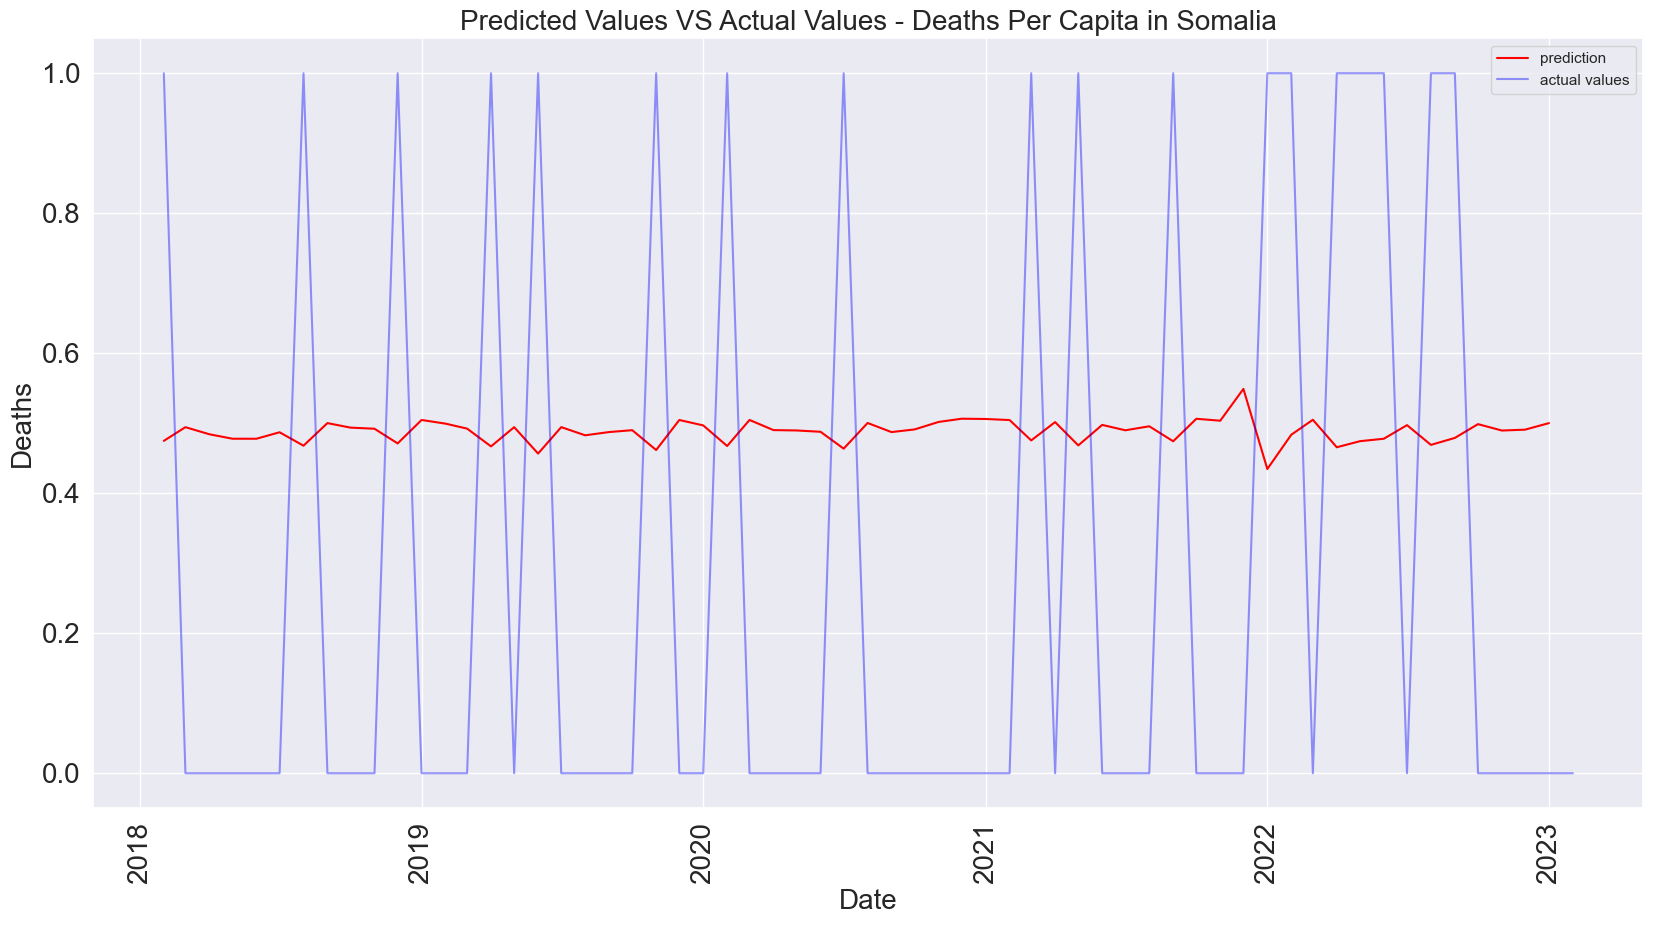

Iraq - Precision: 0.0, Recall: 0.0


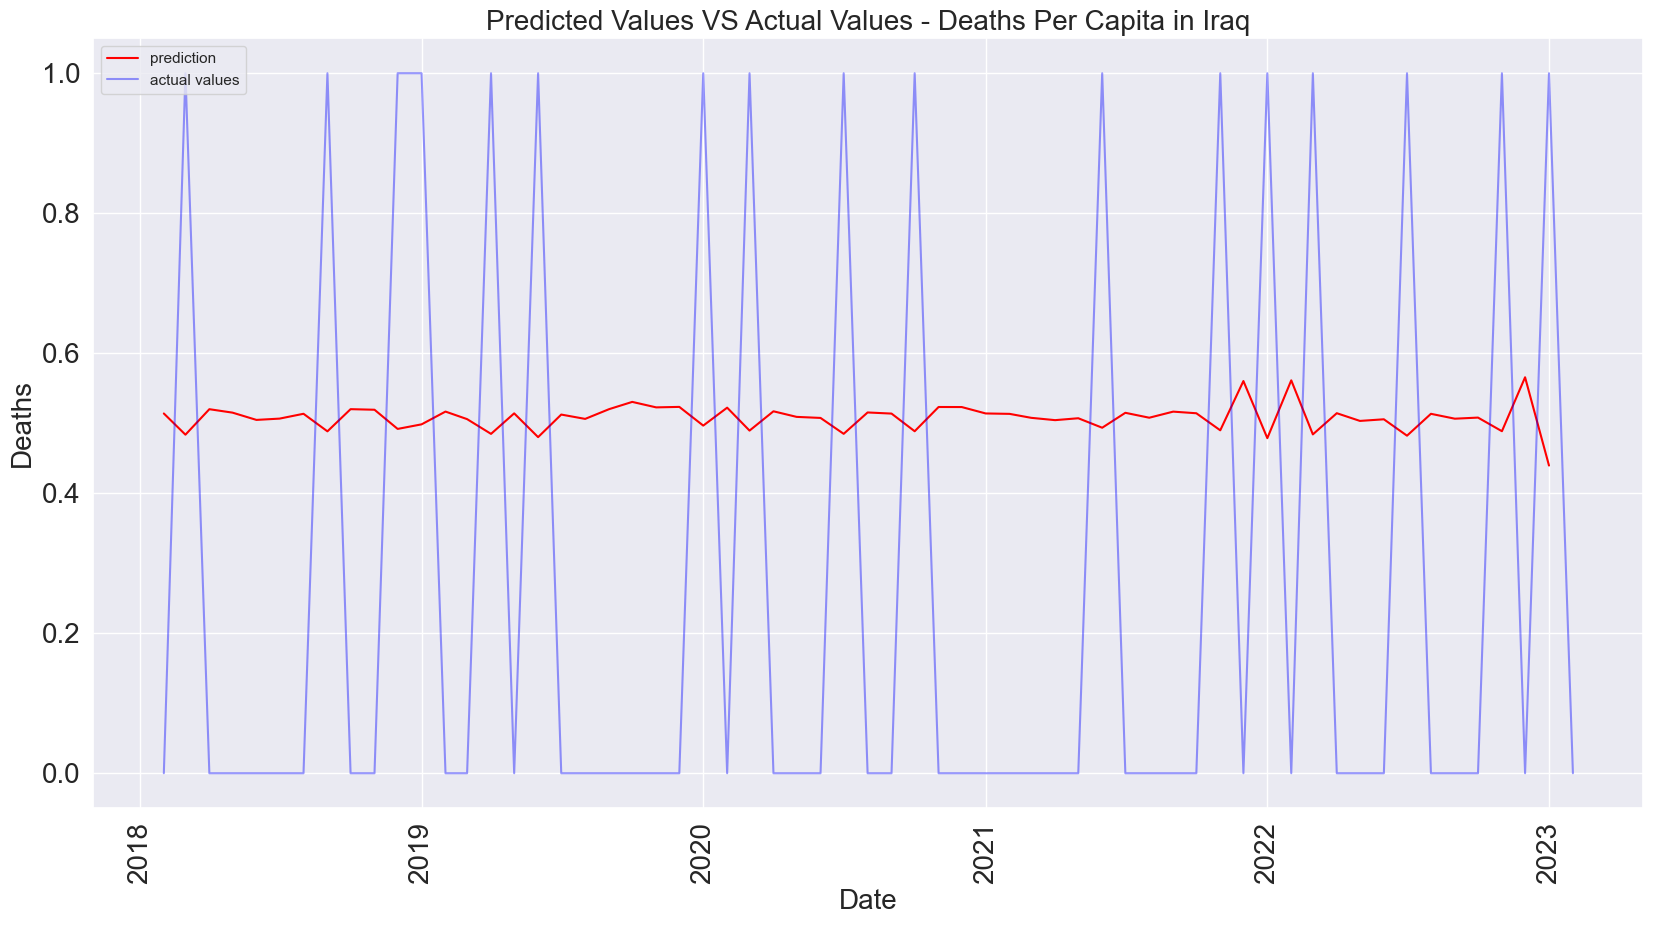

Sudan - Precision: 0.23529411764705882, Recall: 0.10526315789473684


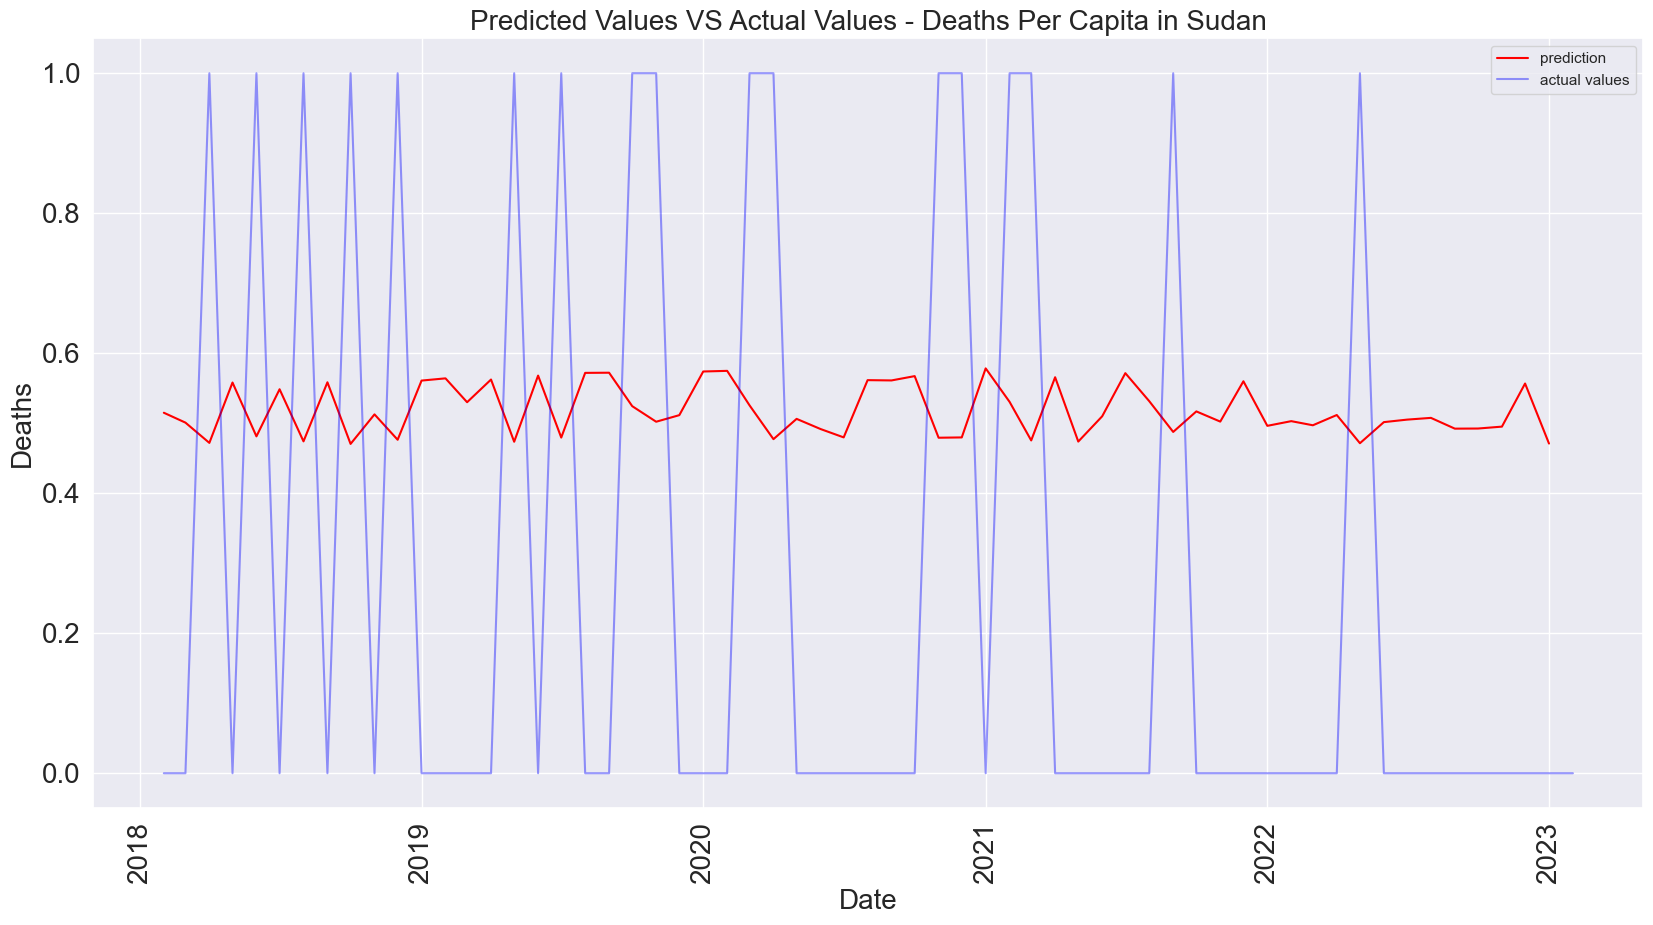

Congo, The Democratic Republic of the - Precision: 0.0, Recall: 0.0


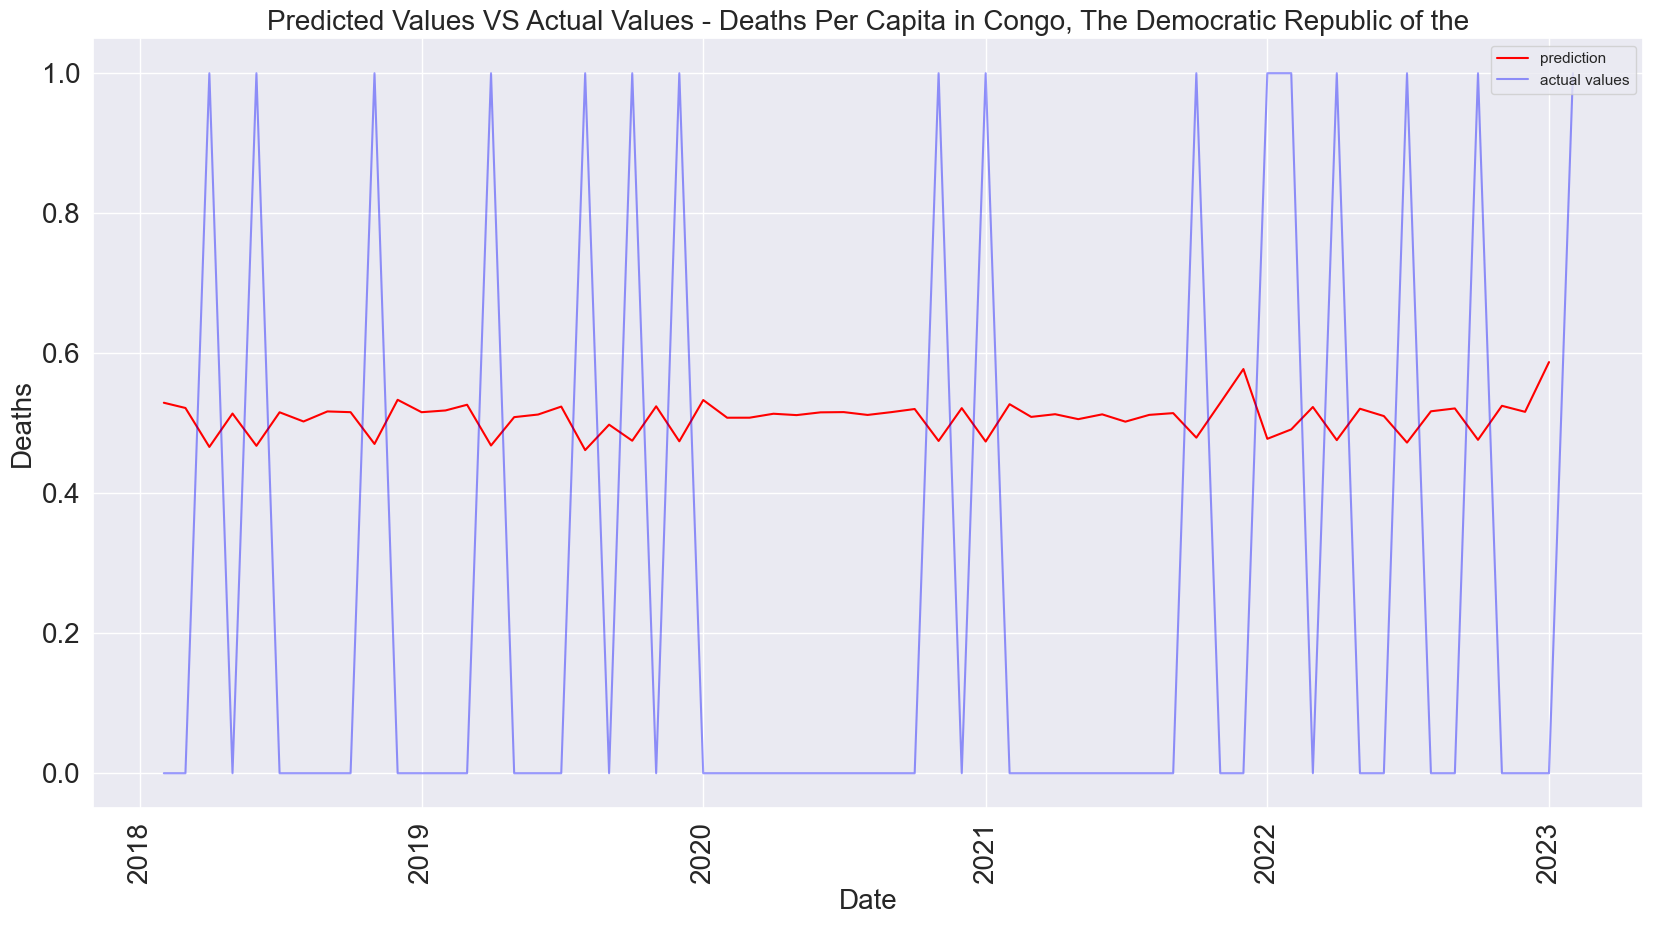

Central African Republic - Precision: 0.058823529411764705, Recall: 0.023255813953488372


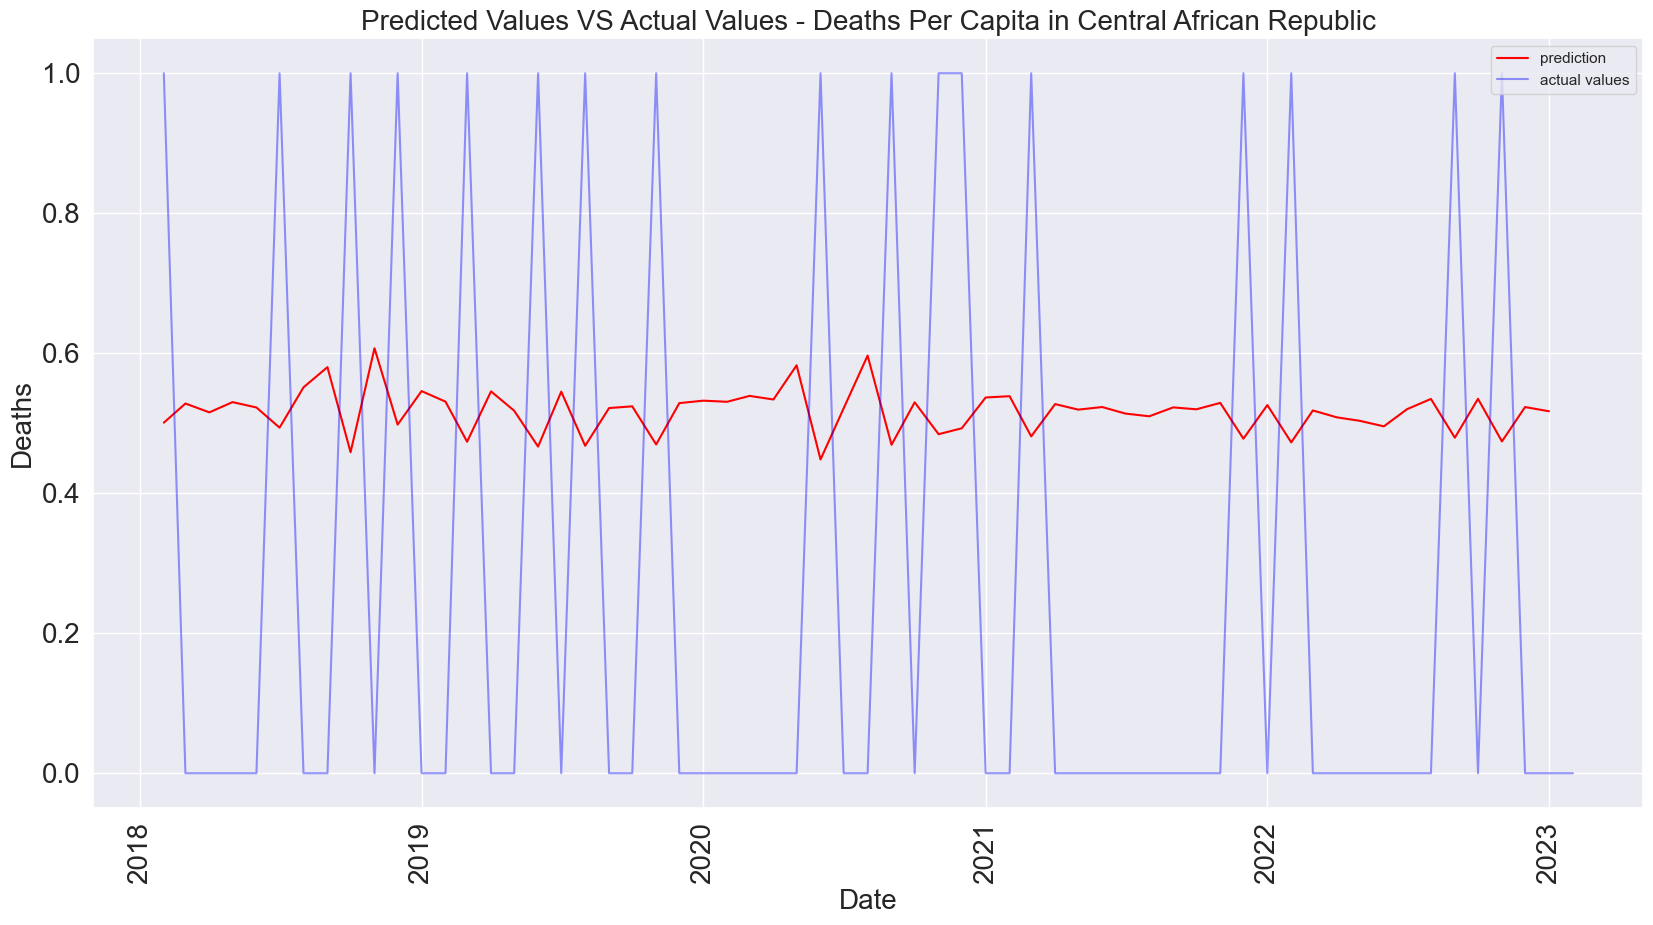

Nigeria - Precision: 0.0, Recall: 0.0


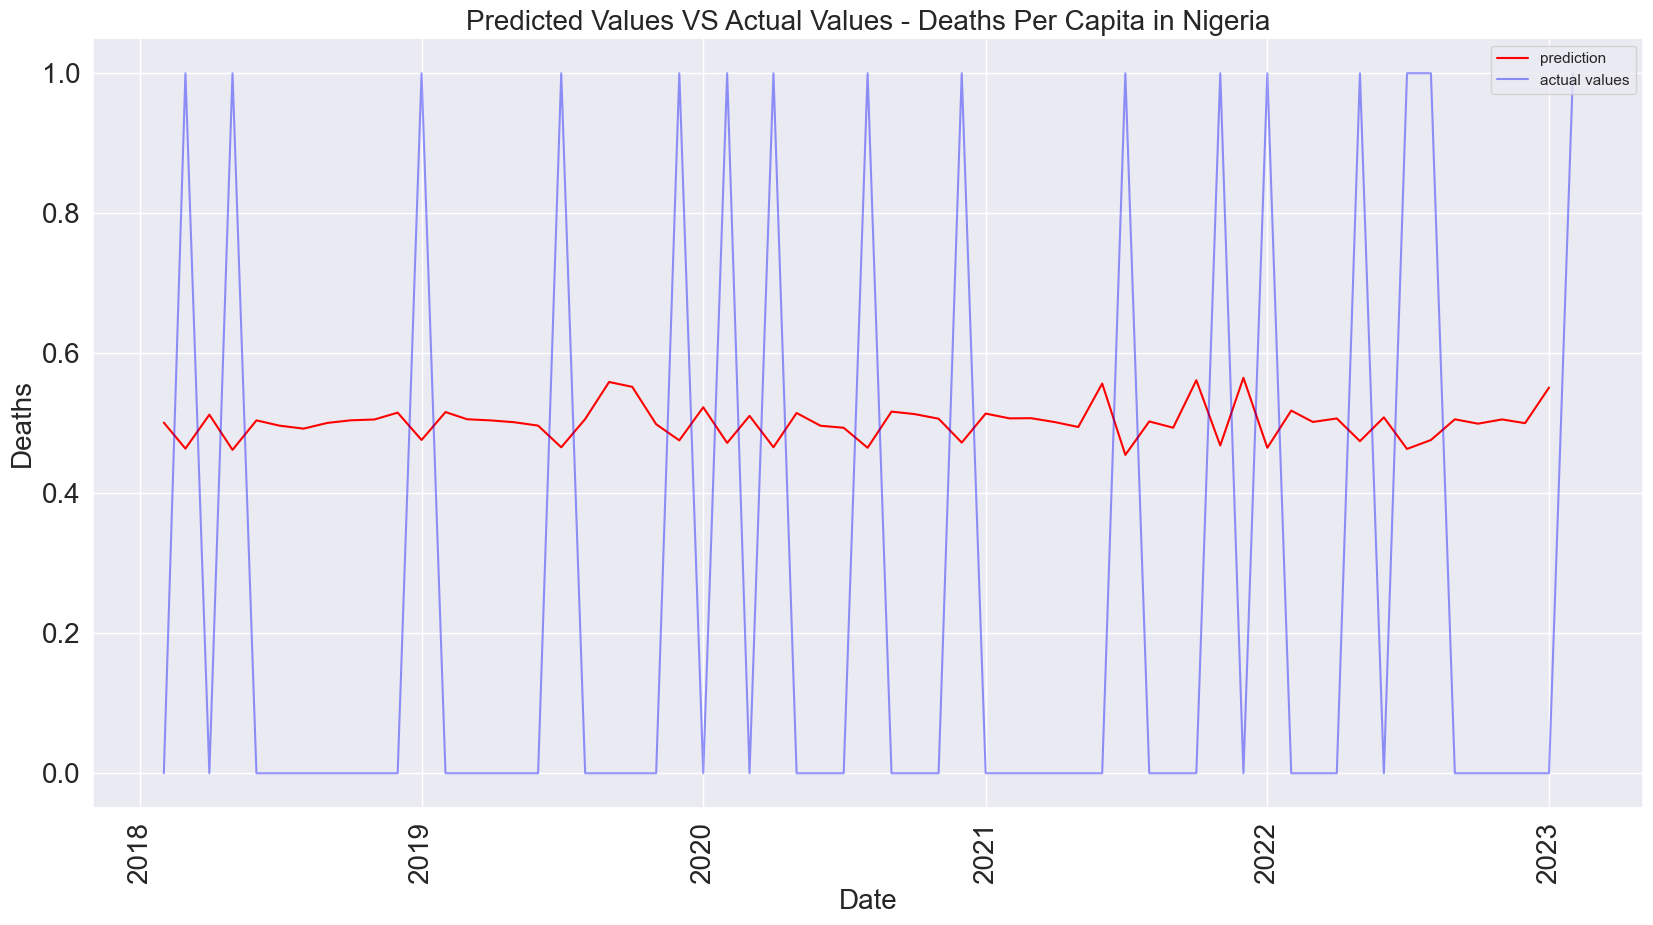

Israel - Precision: 0.21052631578947367, Recall: 0.125


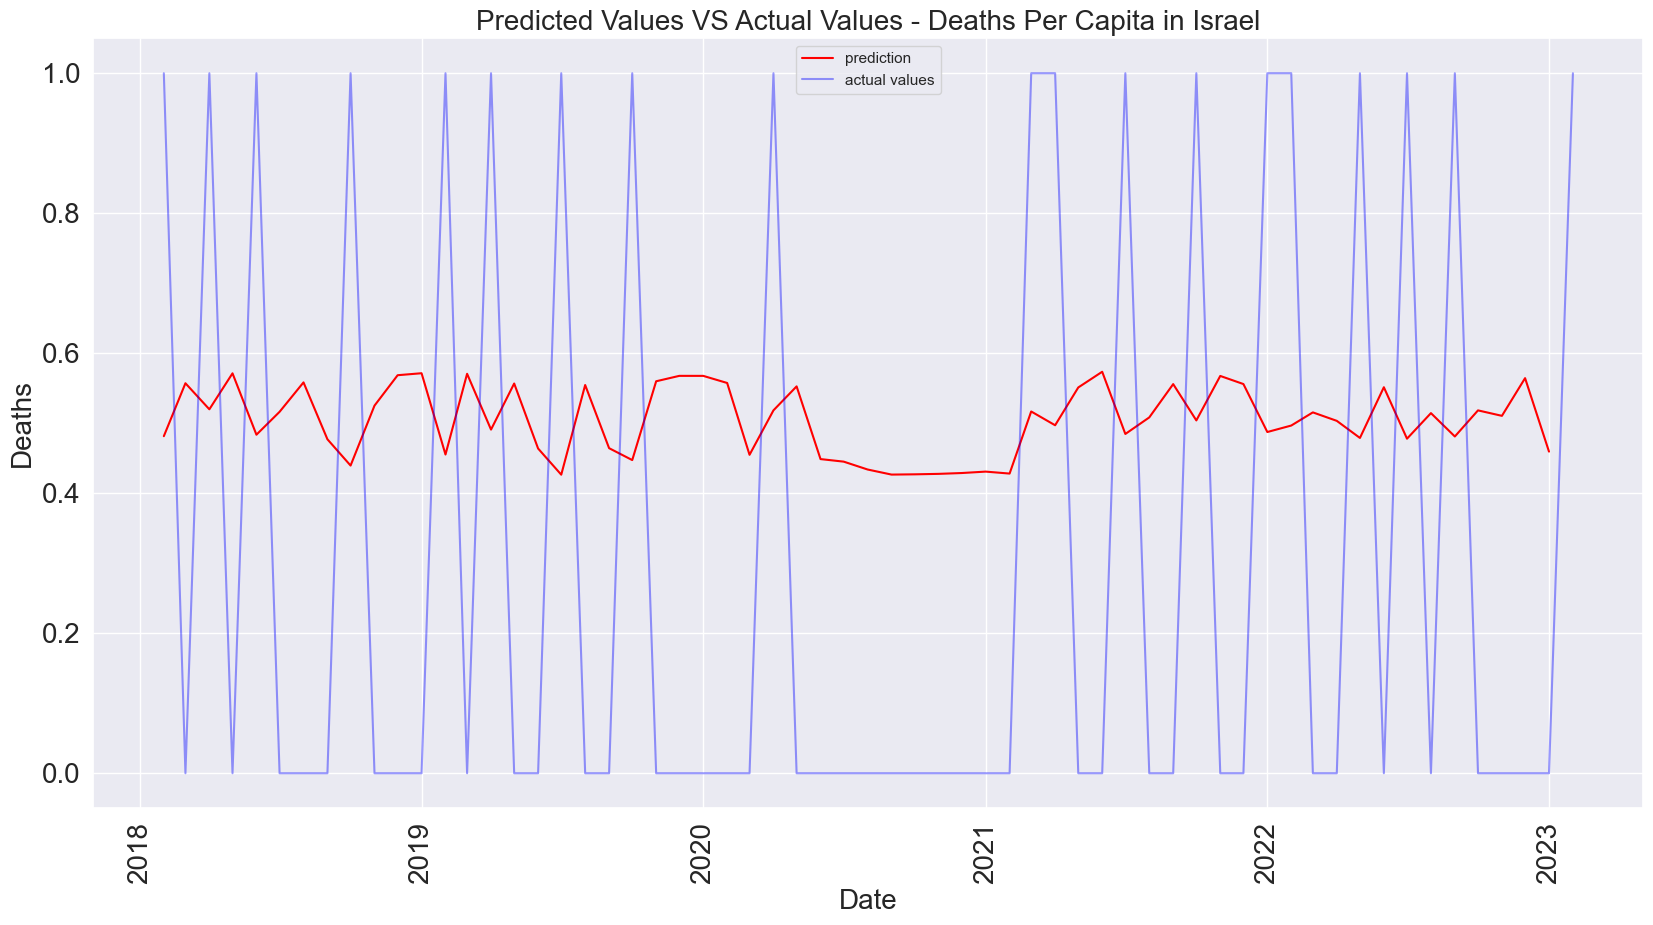

Yemen - Precision: 0.0, Recall: 0.0


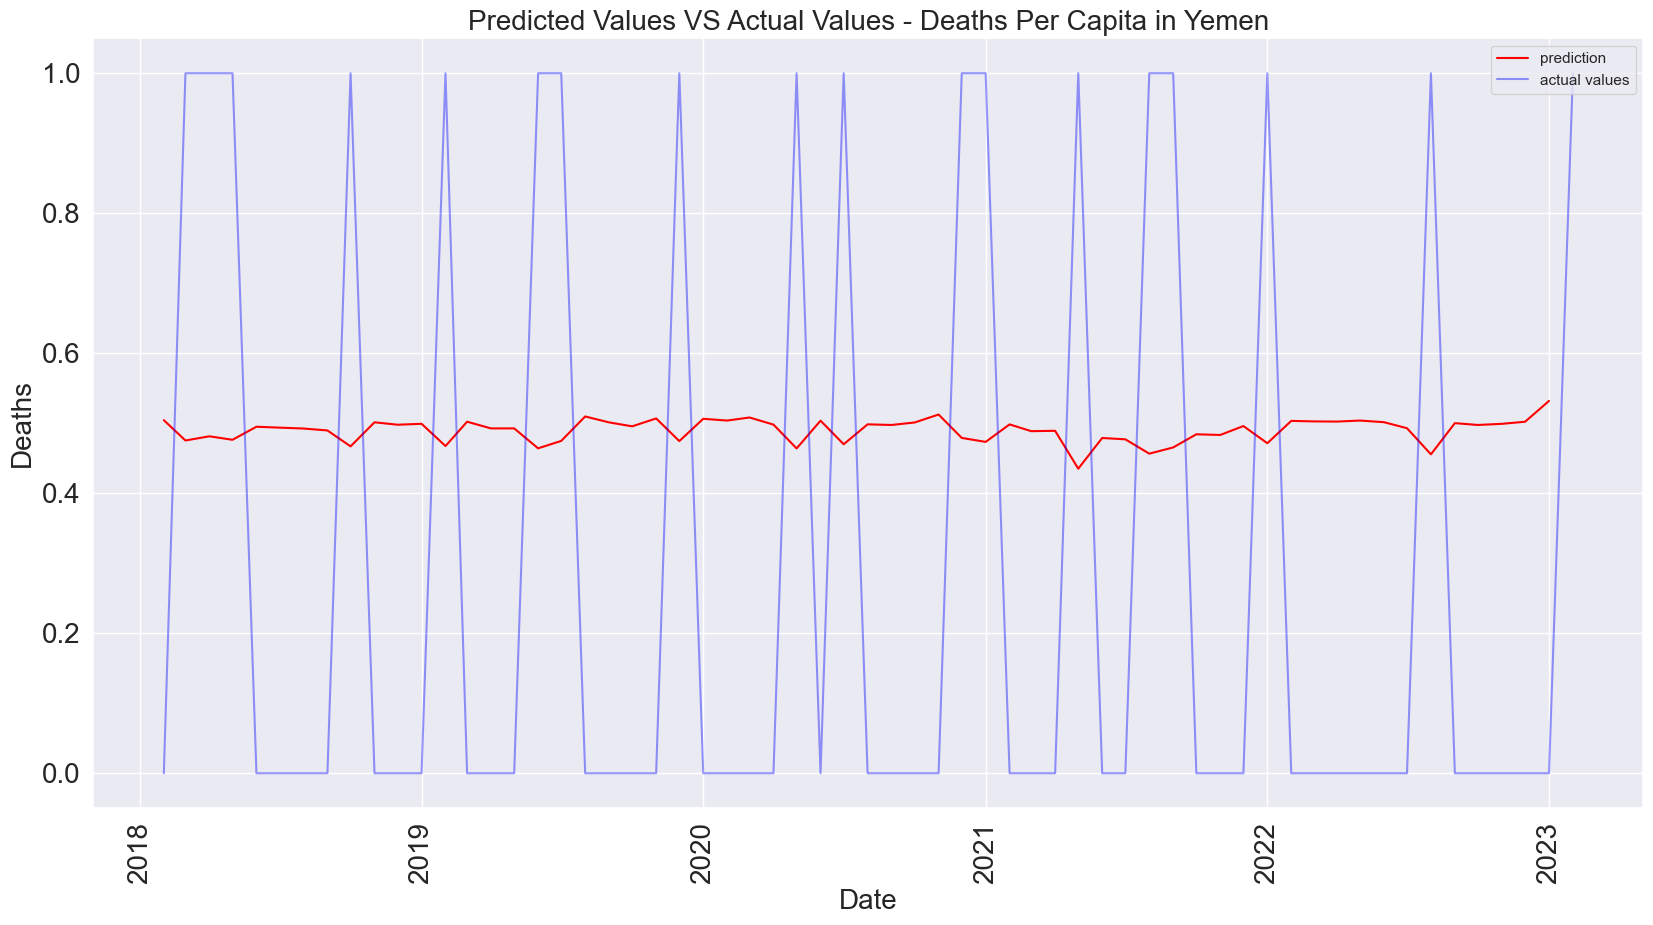

Syrian Arab Republic - Precision: 0.2857142857142857, Recall: 0.08


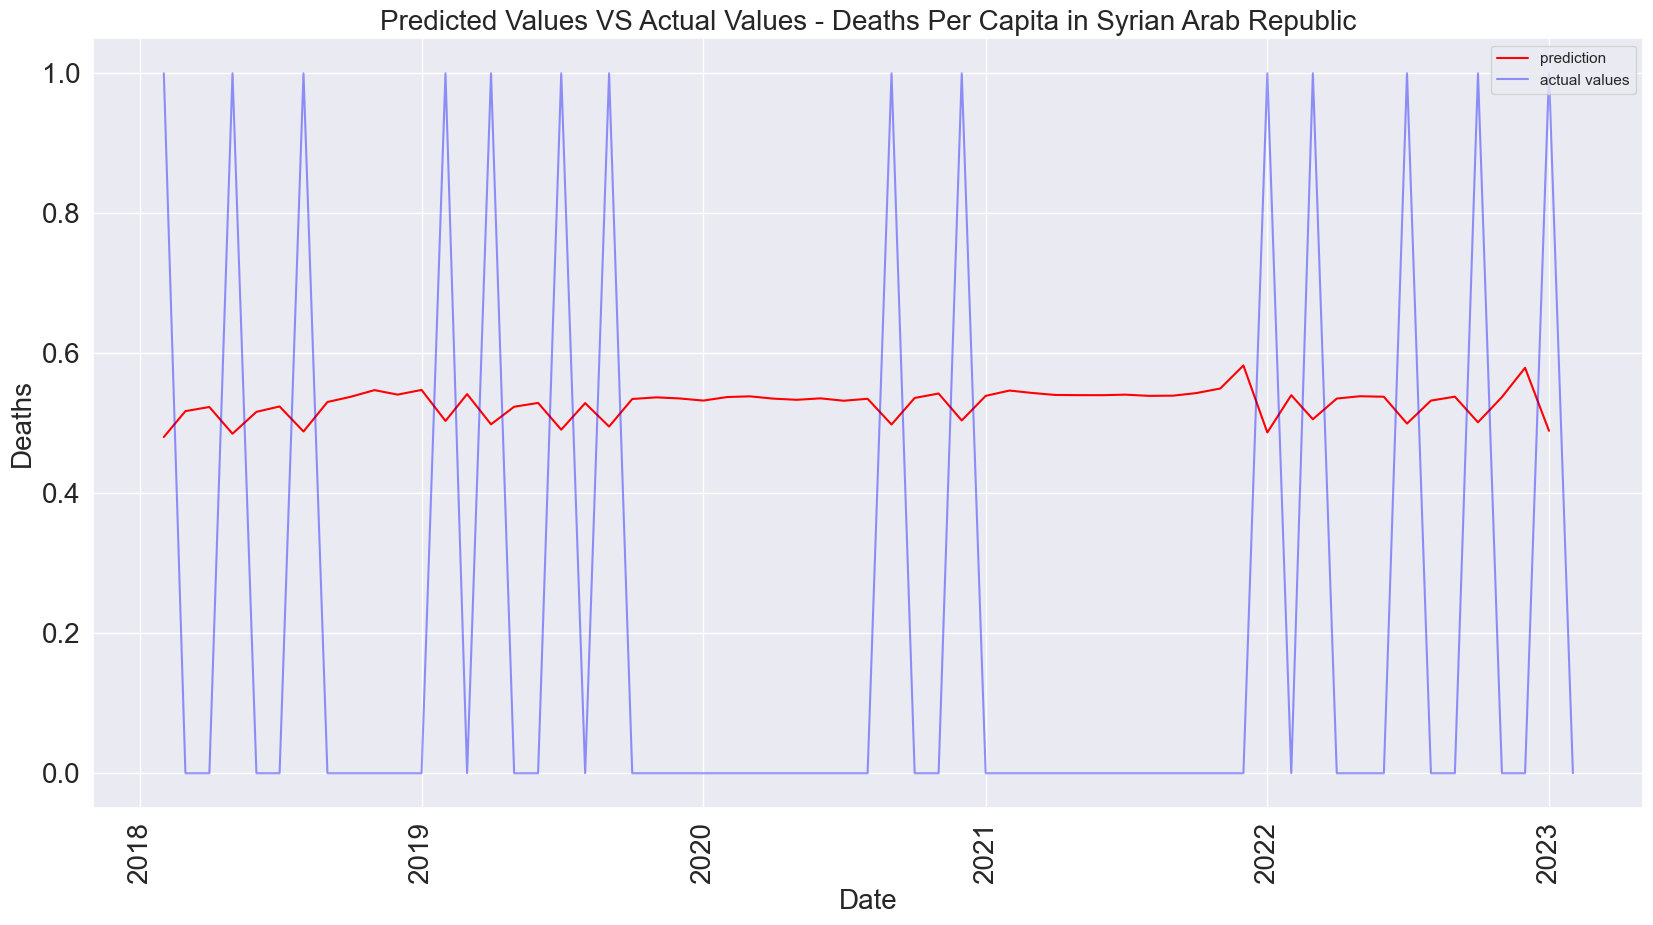

Mexico - Precision: 0.0, Recall: 0.0


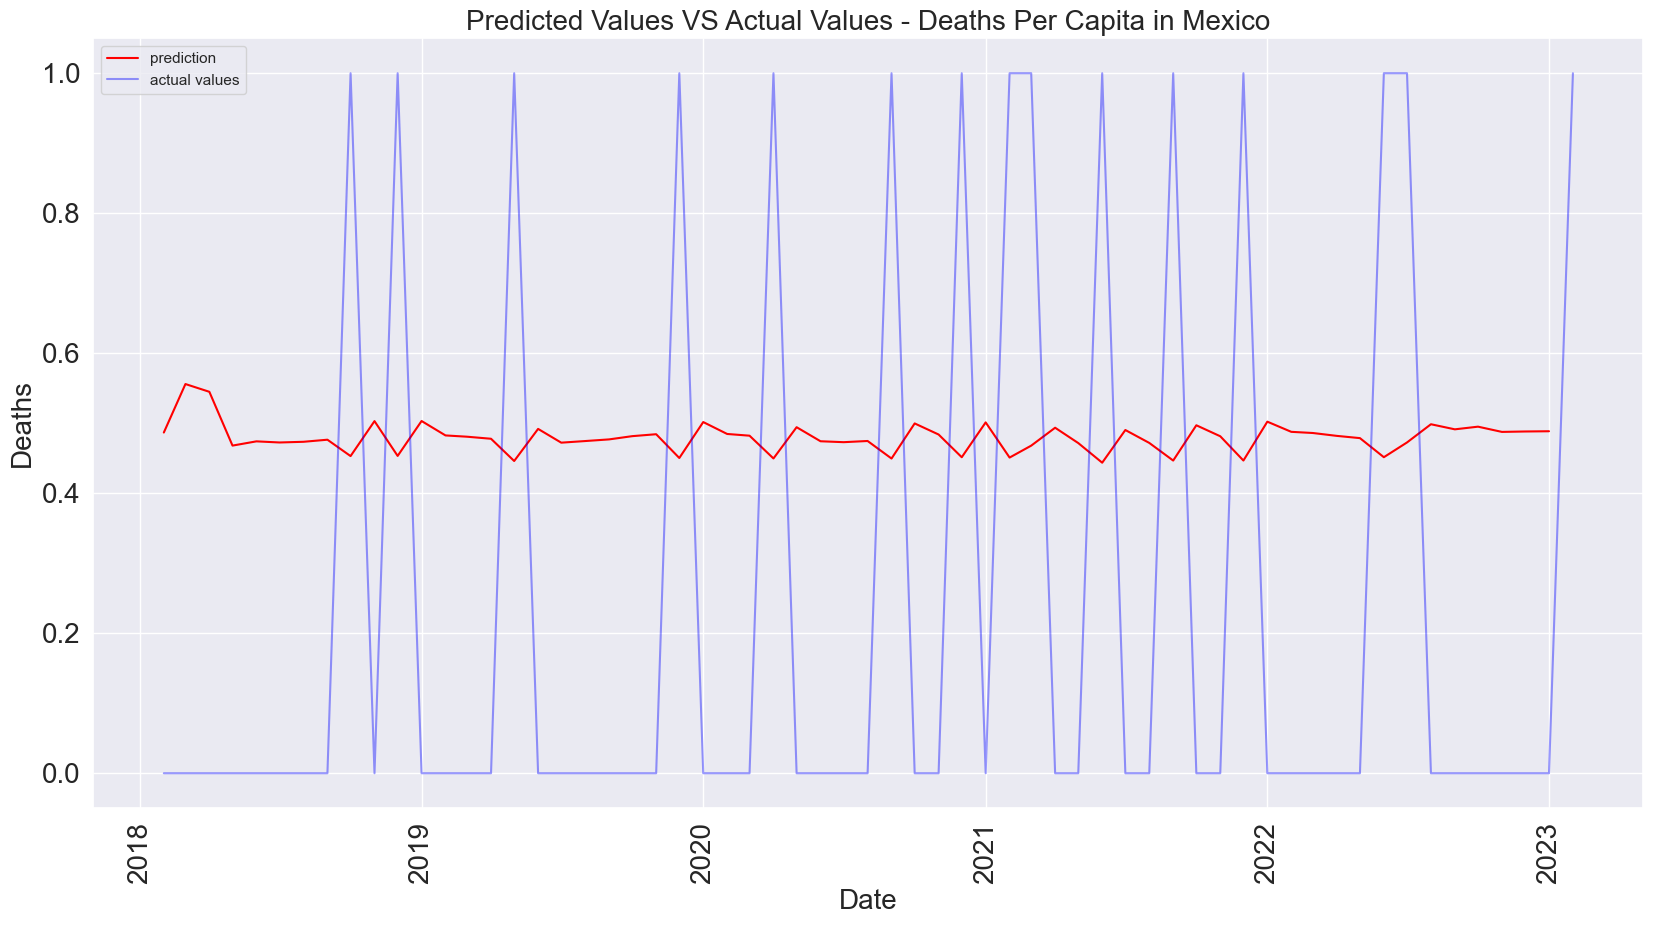

In [154]:
plot_country_data(('escalation', 'combined_vars'), top_10_country_names, -1)